In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels
from collections import Counter
import cpi
import ast
import json
import datetime
from sklearn.decomposition import PCA
from collections import Counter
from wordcloud import WordCloud, STOPWORDS 

In [8]:
# Common functions

# Source: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

def plot_itemset(title, result, dataset_size, rotation=90):
    plt.figure(figsize=(20,12))
    sns.barplot([", ".join(list(x)) for x in result["itemsets"]], [x * dataset_size for x in result["support"]])
    plt.xticks(fontsize=12,rotation=rotation)
    plt.title(title,fontsize=20)
    plt.show()
    
def calculate_support(min_occurence_number, dataset_size):
    return min_occurence_number / dataset_size

In [3]:
dataset_original = pd.read_csv('./tmdb-box-office-prediction/train.csv')
dataset_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [4]:
dataset = dataset_original.copy()

def fix_date(date):
    x = pd.to_datetime(date, format="%m/%d/%y")
    if x.year > 2020:
        year = x.year - 100
    else:
        year = x.year
    return datetime.datetime(year,x.month,x.day)

dataset["release_date"] = dataset_original["release_date"].apply(fix_date)

def adjust_price_to_inflation(price, date):
    return int(cpi.inflate(price, date.year))

dataset["budget"] = dataset.apply(lambda x: adjust_price_to_inflation(x["budget"], x["release_date"]), axis=1)
dataset["revenue"] = dataset.apply(lambda x: adjust_price_to_inflation(x["revenue"], x["release_date"]), axis=1)

In [5]:
print("Oldest: ", dataset["release_date"].min())
print("Newest: ", dataset["release_date"].max())

Oldest:  1921-01-21 00:00:00
Newest:  2017-07-20 00:00:00


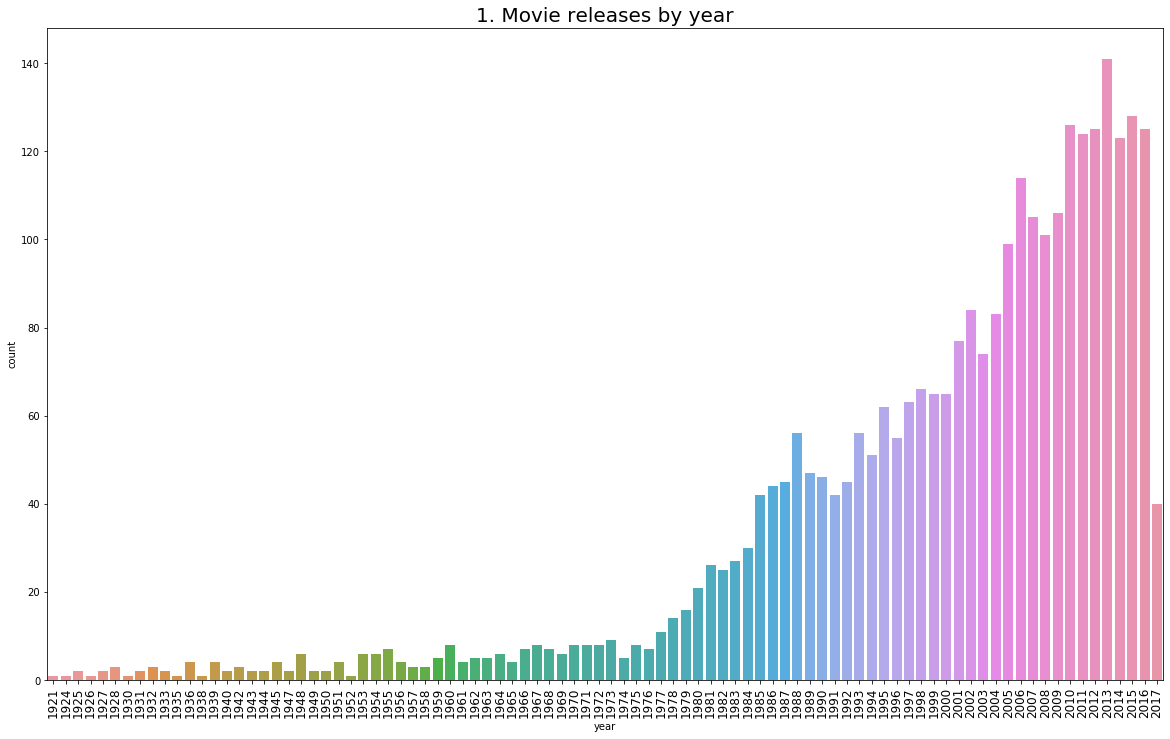

In [6]:
plt.figure(figsize=(20,12))
sns.countplot(dataset['release_date'].dt.year.sort_values())
plt.title("1. Movie releases by year",fontsize=20)
plt.xticks(fontsize=12,rotation=90)
plt.xlabel("year")
plt.show()

Nasz zbiór danych posiada więcej filmów z lat współczesnych

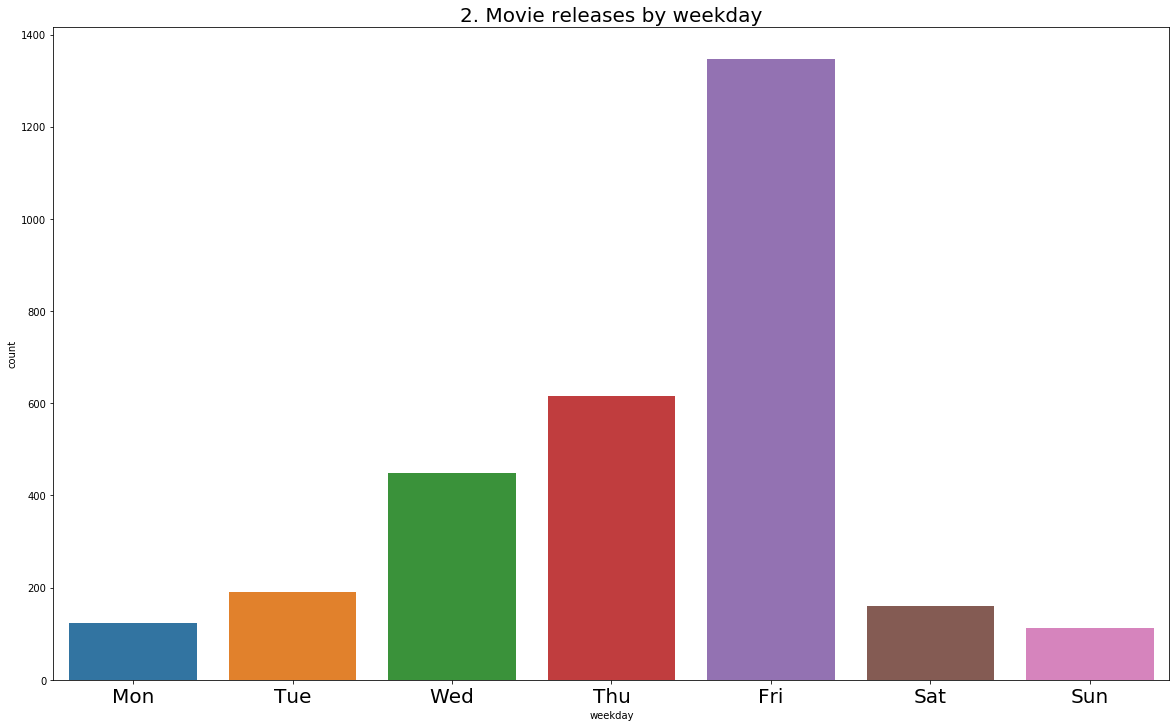

In [7]:
plt.figure(figsize=(20,12))
sns.countplot(dataset['release_date'].dt.weekday.sort_values())
plt.title("2. Movie releases by weekday",fontsize=20)
loc, _ = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("weekday")
plt.show()

Najwięcej filmów wydaje się w dni przed weekendem - środę, czwartek i piątek, najmniej natomiast w poniedziałek, wtorek, sobotę i niedzielę

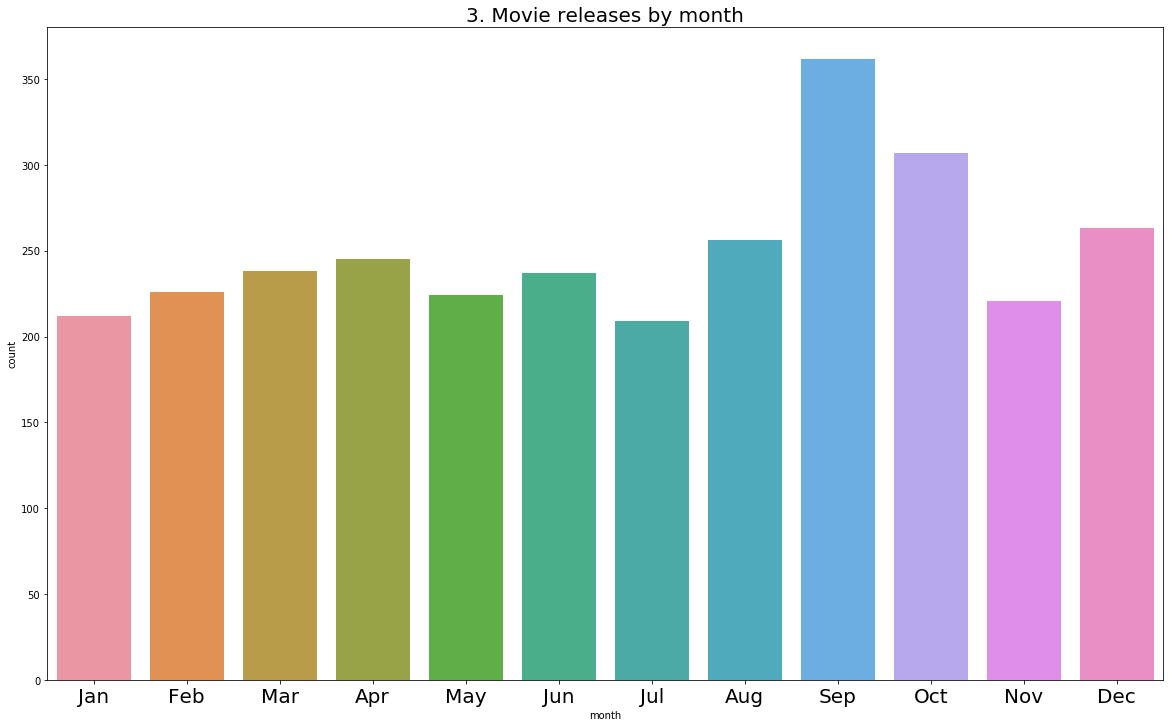

In [8]:
plt.figure(figsize=(20,12))
sns.countplot(dataset['release_date'].dt.month.sort_values())
plt.title("3. Movie releases by month",fontsize=20)
loc, _ = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("month")
plt.show()

Ilość filmów wydawanych w ciągu roku jest podobna, najwięcej filmów zostało wydanych we wrześniu a najmniej w lipcu

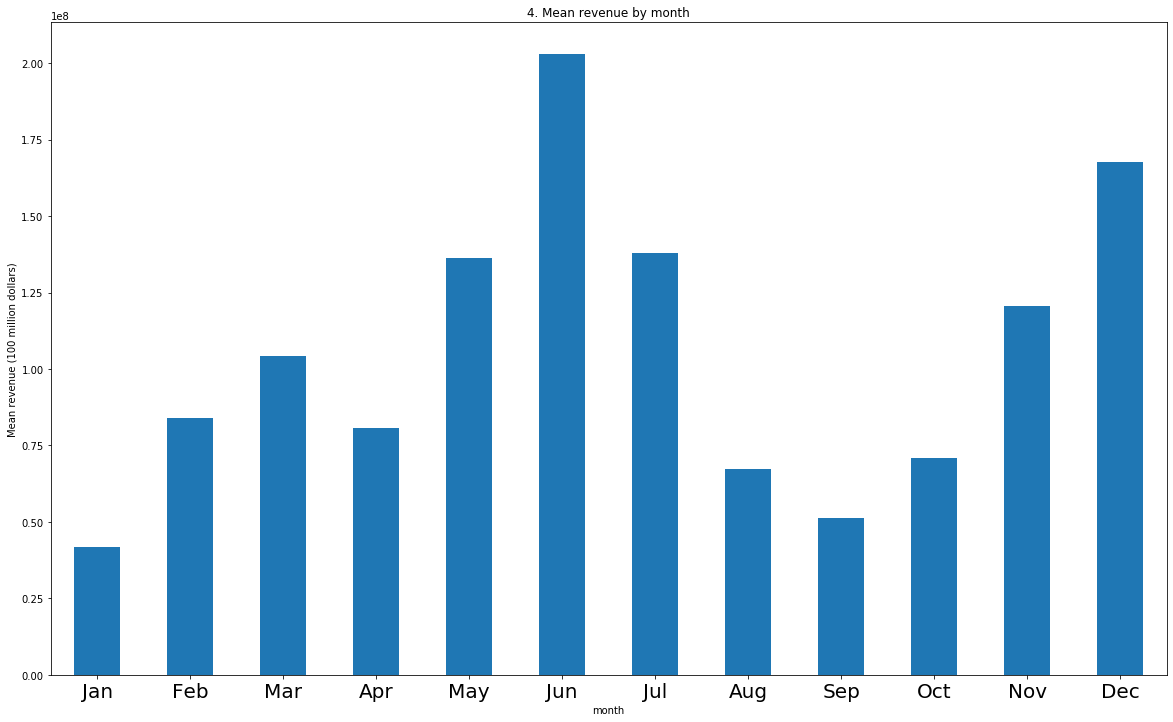

In [9]:
plt.figure(figsize=(20,12))
dataset.groupby(dataset["release_date"].dt.month).agg('mean')['revenue'].plot(kind='bar',rot=0)
plt.ylabel('Mean revenue (100 million dollars)')
plt.title("4. Mean revenue by month")
loc, _ = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("month")
plt.show()

Średnio najwięcej przychodów przynoszą filmy wydane w czerwcu a najmniej filmy wydane w styczniu

In [10]:
import ast
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
 
dataset = text_to_dict(dataset)

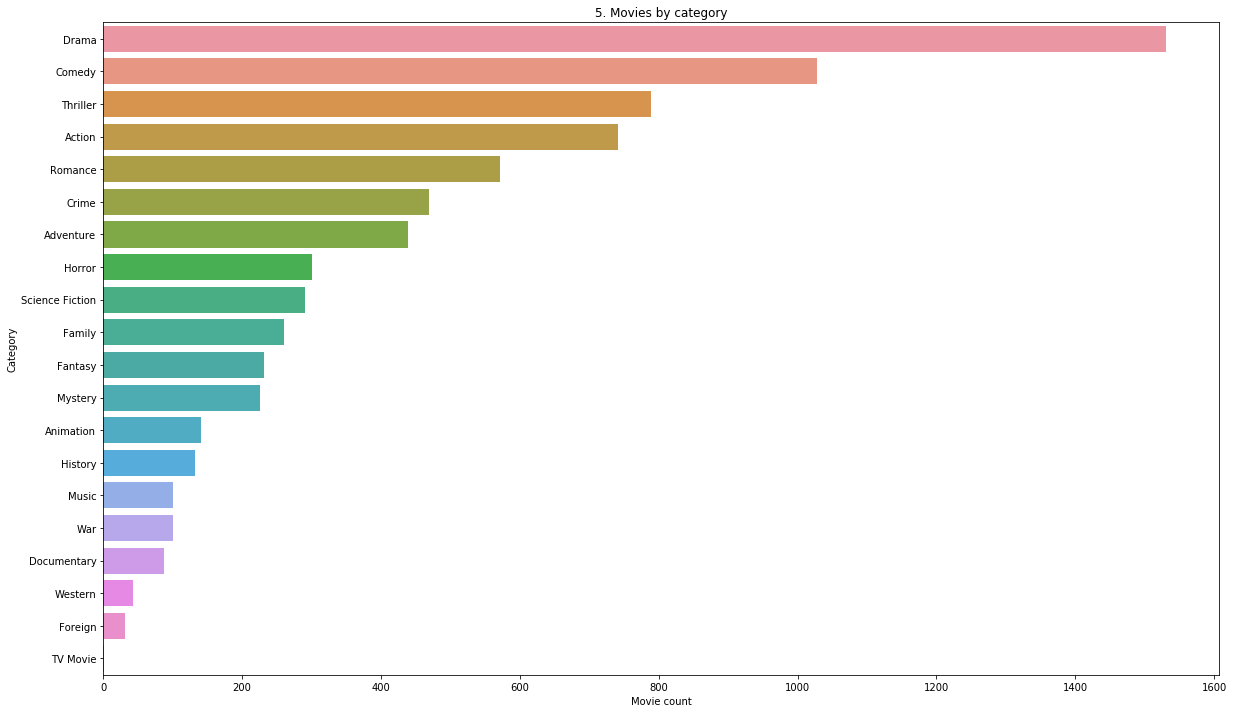

In [11]:
plt.figure(figsize=(20,12))
genre=dataset['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in genre for i in j]).most_common(20)
sns.barplot([val[1] for val in count],[val[0] for val in count])
plt.title("5. Movies by category")
plt.xlabel("Movie count")
plt.ylabel("Category")
plt.show()

Najwięcej wydanych zostało dramatów a najmniej westernów

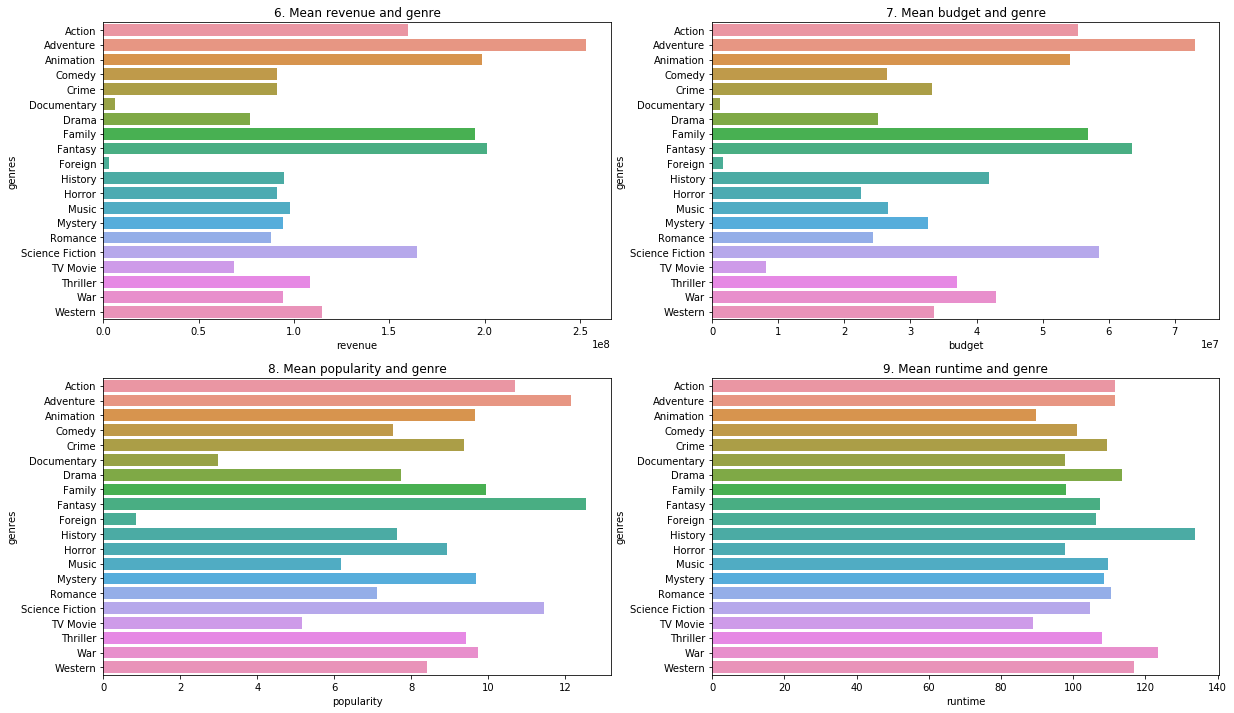

In [12]:
genres = dataset.explode("genres").copy()
genres = genres[genres.genres.notnull()].reset_index(drop=True)
genres["genres"]=genres["genres"].apply(lambda x : x['name'])
genres=genres.groupby(genres.genres).agg('mean')
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plt.title("6. Mean revenue and genre")
sns.barplot(genres['revenue'],genres.index)

plt.subplot(2,2,2)
plt.title("7. Mean budget and genre")
sns.barplot(genres['budget'],genres.index)

plt.subplot(2,2,3)
plt.title("8. Mean popularity and genre")
sns.barplot(genres['popularity'],genres.index)

plt.subplot(2,2,4)
plt.title("9. Mean runtime and genre")
sns.barplot(genres['runtime'],genres.index)
plt.show()

Średnie największe przychody przynoszą filmy przygodowe, które posiadają również największe średnie budżety. 

Najmniejszy średni budżet posiadają filmy dokumentalne.

Średnie najmniejsze przychody przynoszą filmy dokumentalne.

Średnio największą popularnością cieszą się filmy fantasy a najmniejszą filmy dokumentalne.

Średnio najdłuższe są filmy historyczne a najkrótsze filmy telewizyjne i aniumacje.

In [13]:
genres

,id,budget,popularity,runtime,revenue
genres,,,,,
Action,1544.605938,5.532984e+07,10.686771,111.547908,1.600906e+08
Adventure,1466.562642,7.307119e+07,12.136292,111.708428,2.534838e+08
Animation,1509.113475,5.418770e+07,9.663479,89.829787,1.986236e+08
Comedy,1507.457198,2.647899e+07,7.514553,101.189873,9.123142e+07
Crime,1547.078891,3.325211e+07,9.372484,109.275053,9.123173e+07
Documentary,1363.701149,1.183166e+06,2.966898,97.816092,6.176284e+06
Drama,1513.161986,2.510553e+07,7.730080,113.603922,7.708735e+07
Family,1456.500000,5.687512e+07,9.926246,98.053846,1.949956e+08
Fantasy,1512.538793,6.345748e+07,12.545494,107.426724,2.010485e+08


Actors number:  38588


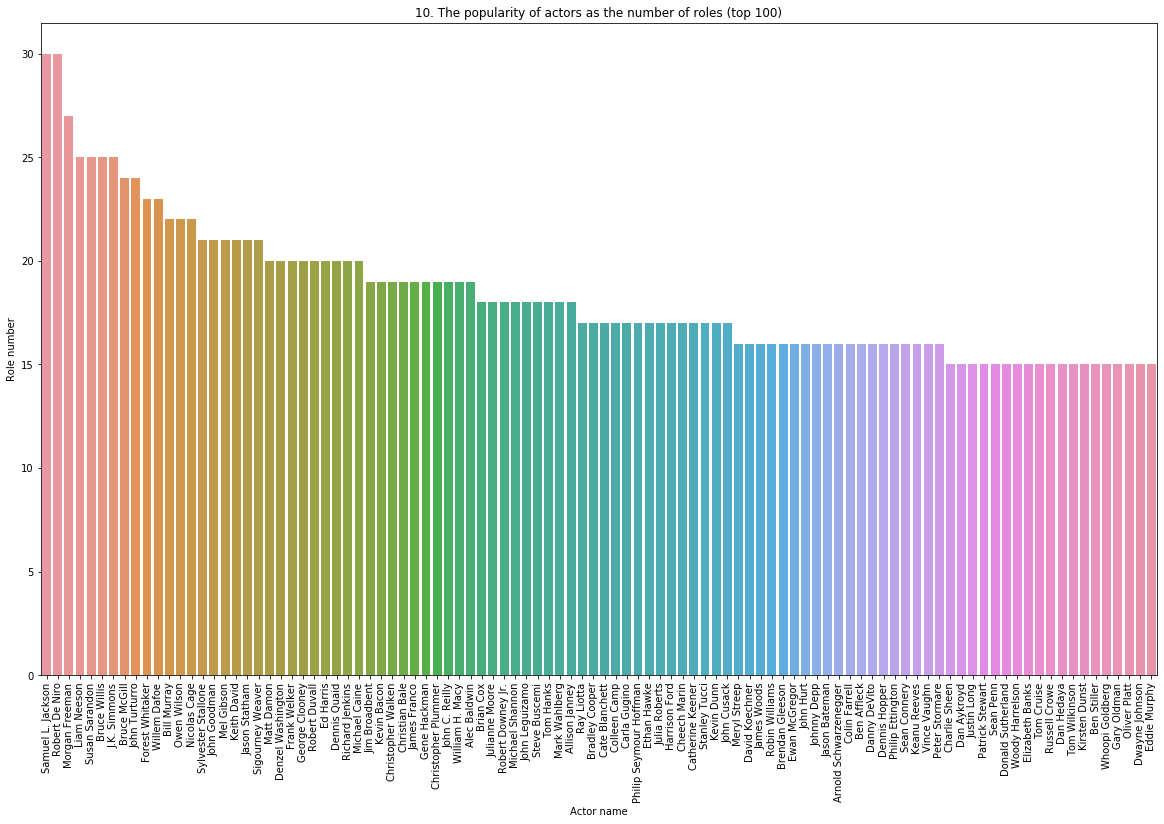

In [14]:
# popularity of an actor expressed as number of films
n = 100
actorMovieDataset = dataset_original[['id','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: {} if pd.isna(x) else [x.get('name') for x in ast.literal_eval(x)])
actorMovieDataset = actorMovieDataset.explode('cast').reset_index(drop=True)
actorMovieDataset = actorMovieDataset.groupby(['cast']).size().reset_index(name='count').sort_values('count', ascending=False)
print("Actors number: ", actorMovieDataset.shape[0])

plt.figure(figsize=(20,12))
sns.barplot(actorMovieDataset['cast'].head(n), actorMovieDataset['count'].head(n))
plt.title("10. The popularity of actors as the number of roles (top {0})".format(n))
plt.xlabel("Actor name")
plt.ylabel("Role number")
plt.xticks(rotation=90)

plt.show()

Liczba aktorów w zbiorze danych wynosi 38588. Pokazanie na jednym wykresie liczby angaży dla wszystkich aktorów jest niewykonalne.

Najpopularniejszymi aktorami są Samuel L. Jackson oraz Robert De Niro. Obaj panowie zagrali w 30 filmach z naszego zbioru danych.

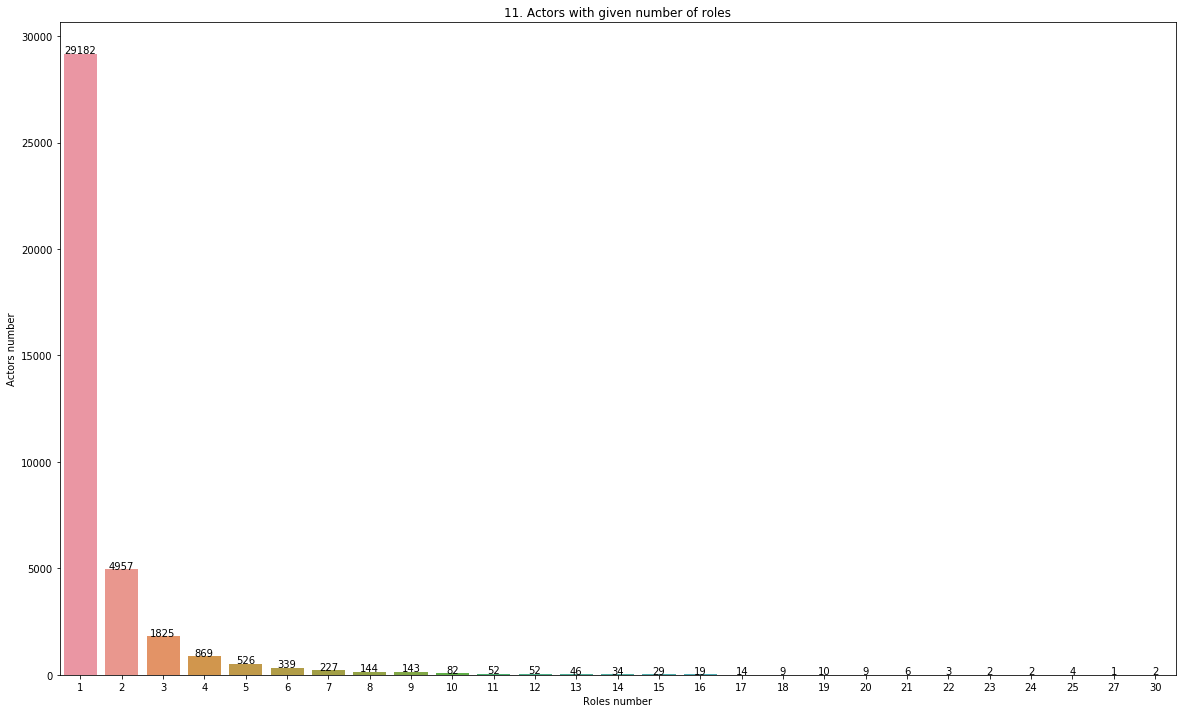

In [15]:
# number of actors with concrette role number
actorMovieDataset = dataset_original[['id','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: {} if pd.isna(x) else [x.get('name') for x in ast.literal_eval(x)])
actorMovieDataset = actorMovieDataset.explode('cast').reset_index(drop=True)
actorMovieDataset = actorMovieDataset.groupby(['cast']).size().reset_index(name='count').sort_values('count', ascending=False)
actorMovieRolesDataset = actorMovieDataset.groupby(['count']).size().reset_index(name='actors_with_given_role_number')
x = actorMovieRolesDataset['count']
y = actorMovieRolesDataset['actors_with_given_role_number']

plt.figure(figsize=(20,12))
#plt.subplot(2,1,1)
snbp = sns.barplot(x='count',y='actors_with_given_role_number',data=actorMovieRolesDataset)
show_values_on_bars(snbp, "v", 0.5)
plt.title("11. Actors with given number of roles")
plt.xlabel("Roles number")
plt.ylabel("Actors number")
plt.show()


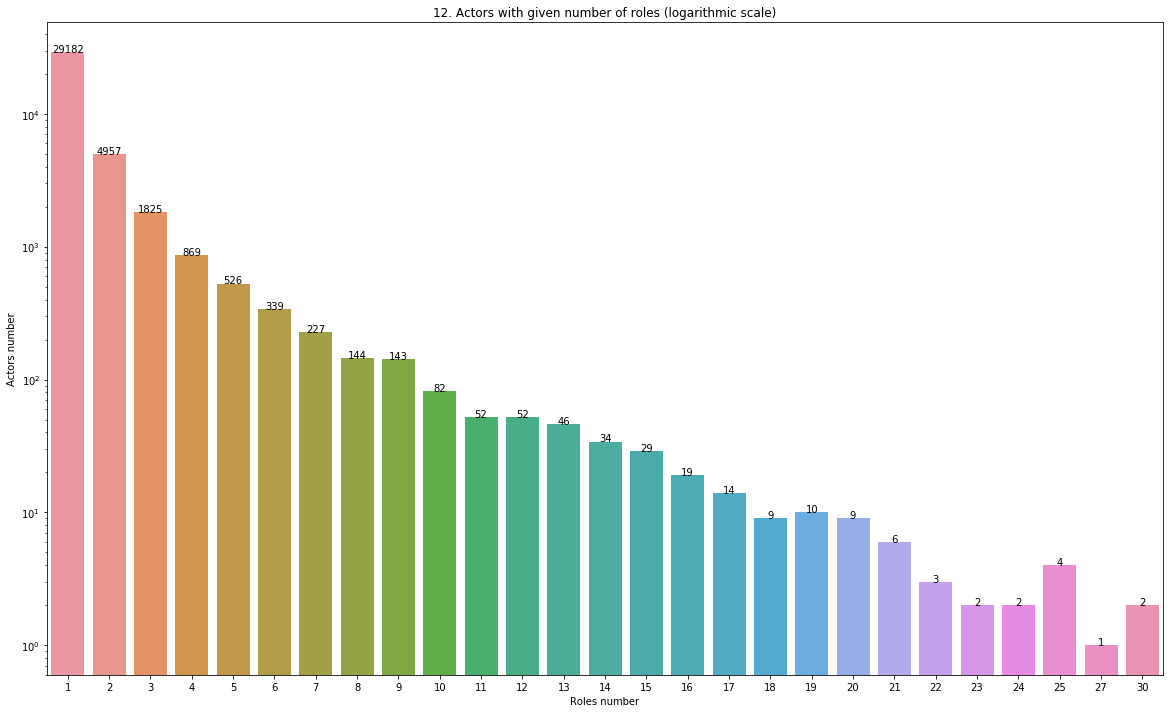

In [16]:
plt.figure(figsize=(20,12))
#plt.subplot(2,1,2)
snbp = sns.barplot(x='count',y='actors_with_given_role_number',data=actorMovieRolesDataset)
show_values_on_bars(snbp, "v", 0.5)
snbp.set_yscale('log')
plt.title("12. Actors with given number of roles (logarithmic scale)")
plt.xlabel("Roles number")
plt.ylabel("Actors number")

plt.show()

Dominujący są aktorzy, którzy zagrali w jednym filmie. Liczba aktorów, która zagrała tylko w jednym filmie stanowi ok. 75.6% wszystkich aktorów z zbiorze danych.

Wśród aktorów wysoką popularność przejawiającą się, jako duża liczba angaży, wykazuje wąskie grono osób. Tylko 376 aktorów zagrało w co najmniej 10 filmach, co stanowi zaledwie ok. 0.9%.

Liczba aktorów posiadających daną liczbę angaży maleje wykładniczo wraz z rosnącą liczbą zagranych ról.

In [17]:
oscars = pd.read_csv('./tmdb-box-office-prediction/the_oscar_award.csv')
oscars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10395 entries, 0 to 10394
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year_film      10395 non-null  int64 
 1   year_ceremony  10395 non-null  int64 
 2   ceremony       10395 non-null  int64 
 3   category       10395 non-null  object
 4   name           10395 non-null  object
 5   film           10091 non-null  object
 6   winner         10395 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 497.5+ KB


In [18]:
oscars.head(10)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
5,1927,1928,1,ART DIRECTION,Rochus Gliese,Sunrise,False
6,1927,1928,1,ART DIRECTION,William Cameron Menzies,The Dove;,True
7,1927,1928,1,ART DIRECTION,Harry Oliver,7th Heaven,False
8,1927,1928,1,CINEMATOGRAPHY,George Barnes,The Devil Dancer;,False
9,1927,1928,1,CINEMATOGRAPHY,Charles Rosher,Sunrise,True


In [19]:
oscars_winners = oscars[oscars["winner"] == True].drop(columns=["winner", "year_film", "year_ceremony", "ceremony", "category", "name"])
oscars_winners = oscars_winners[oscars_winners["film"].notnull()]

dataset_lc = dataset.copy()
oscars_winners_lc = oscars_winners.copy()
dataset_lc['title'] = dataset_lc['title'].str.lower()
oscars_winners_lc['film'] = oscars_winners_lc['film'].str.lower()

oscar_movies = pd.merge(left=dataset_lc, right=oscars_winners_lc, left_on='title', right_on='film').drop_duplicates(subset="id")
oscar_movies = oscar_movies.drop(columns=["film", "id"])
oscar_movies

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,{},3563750,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,...,2014-10-10,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",14138371
3,"[{'id': 1575, 'name': 'Rocky Collection', 'pos...",4493093,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0075148,en,Rocky,"When world heavyweight boxing champion, Apollo...",14.774066,/i5xiwdSsrecBvO7mIfAJixeEDSg.jpg,...,1976-11-21,119.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,His whole life was a million-to-one shot.,rocky,"[{'id': 240, 'name': 'underdog'}, {'id': 276, ...","[{'cast_id': 16, 'character': 'Rocky Balboa', ...","[{'credit_id': '579948e9c3a36874e9007b0b', 'de...",526748435
6,{},23018337,"[{'id': 18, 'name': 'Drama'}]",http://www.dreamworks.com/ab/,tt0169547,en,American Beauty,"Lester Burnham, a depressed suburban father in...",20.726578,/or1MP8BZIAjqWYxPdPX724ydKar.jpg,...,1999-09-15,122.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Look closer.,american beauty,"[{'id': 255, 'name': 'male nudity'}, {'id': 29...","[{'cast_id': 6, 'character': 'Lester Burnham',...","[{'credit_id': '52fe420ec3a36847f80007c5', 'de...",546757023
11,{},22963203,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,tt0061512,en,Cool Hand Luke,When petty criminal Luke Jackson is sentenced ...,9.718713,/vDwphkloD7ToaDpKASAXGgHOclN.jpg,...,1967-06-22,126.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What we've got here is failure to communicate.,cool hand luke,"[{'id': 378, 'name': 'prison'}, {'id': 526, 'n...","[{'cast_id': 13, 'character': 'Luke Jackson', ...","[{'credit_id': '52fe428ac3a36847f8026d8d', 'de...",124137341
12,{},47460342,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",http://thehatefuleight.com/,tt3460252,en,The Hateful Eight,Bounty hunters seek shelter from a raging bliz...,20.328822,/fqe8JxDNO8B8QfOGTdjh6sPCdSC.jpg,...,2015-12-25,167.0,"[{'iso_639_1': 'es', 'name': 'Español'}, {'iso...",Released,No one comes up here without a damn good reason.,the hateful eight,"[{'id': 801, 'name': 'bounty hunter'}, {'id': ...","[{'cast_id': 22, 'character': 'Major Marquis W...","[{'credit_id': '538aa95ec3a368714e0005b3', 'de...",168009738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,{},8354803,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",NaN,tt0057590,en,Tom Jones,Tom loves Sophie and Sophie loves Tom. But Tom...,3.315827,/7pn0MuzLX0tkBnNymdJtF52QQZV.jpg,...,1963-10-06,128.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Tom Jones! . . . loves and loves and loves and...,tom jones,"[{'id': 5626, 'name': 'from rags to riches'}, ...","[{'cast_id': 6, 'character': 'Tom Jones', 'cre...","[{'credit_id': '52fe4421c3a36847f8084025', 'de...",314140627
510,{},67924584,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",http://www.lesmiserablesfilm.com,tt1707386,en,Les Misérables,An adaptation of the successful stage musical ...,13.524080,/qEsrAHoxj746FRb7OLGYjrx1AI3.jpg,...,2012-12-18,157.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fight. Dream. Hope. Love.,les misérables,"[{'id': 254, 'name': 'france'}, {'id': 642, 'n...",{},{},491963031
513,"[{'id': 387219, 'name': 'The Hustler Collectio...",17100802,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0054997,en,The Hustler,Fast Eddie Felson is a small-time pool hustler...,9.333533,/u38NLUtWarEbv2gZGOnHhf6akWC.jpg,...,1961-09-25,134.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They called him Fast Eddie. He was a wi

In [20]:
dataset_oscars = oscar_movies

In [21]:
print("Oldest: ", dataset_oscars["release_date"].min())
print("Newest: ", dataset_oscars["release_date"].max())

Oldest:  1924-03-18 00:00:00
Newest:  2017-03-24 00:00:00


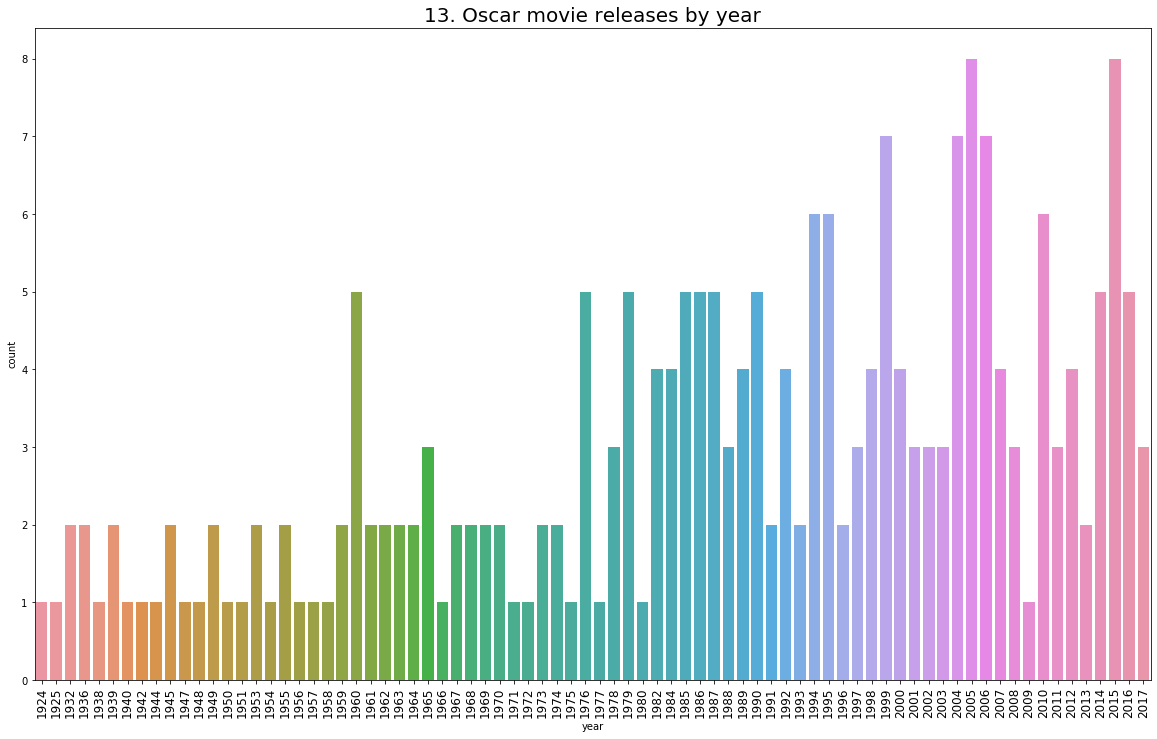

In [22]:
plt.figure(figsize=(20,12))
sns.countplot(dataset_oscars['release_date'].dt.year.sort_values())
plt.title("13. Oscar movie releases by year",fontsize=20)
plt.xticks(fontsize=12,rotation=90)
plt.xlabel("year")
plt.show()

Rozkład filmów oscarowych jest podobny we wszystkich latach. Nasz oryginalny zbiór nie zawiera wszystkich filmów oscarowych

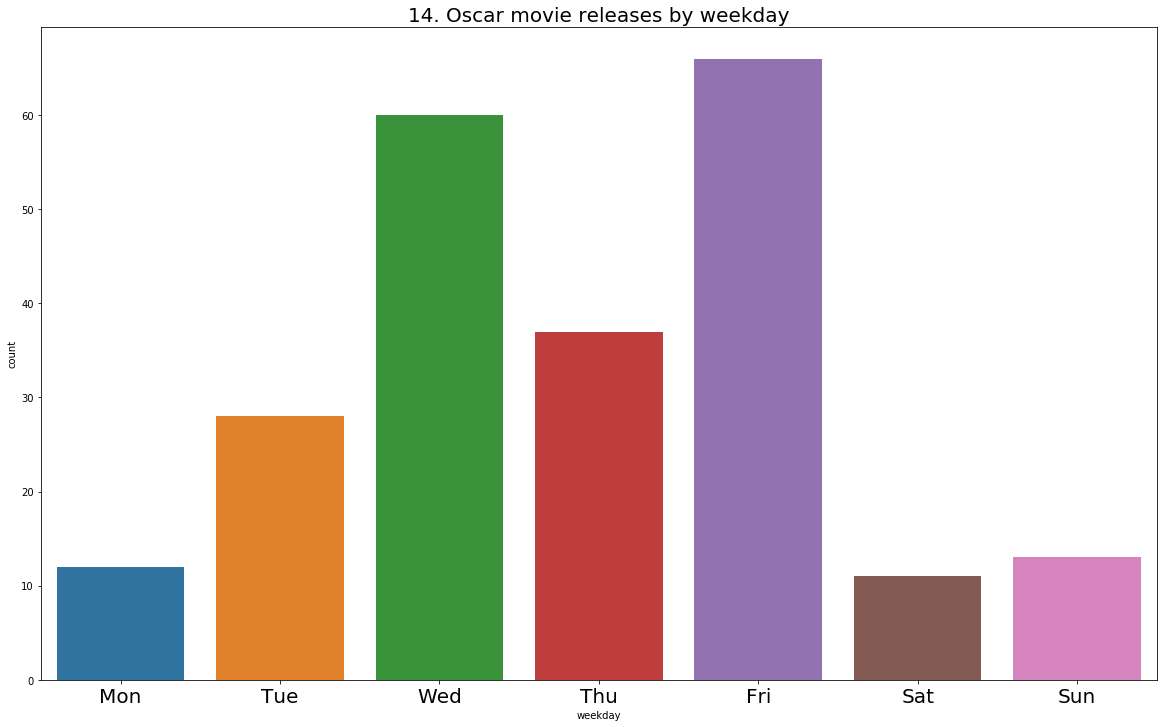

In [23]:
plt.figure(figsize=(20,12))
sns.countplot(dataset_oscars['release_date'].dt.weekday.sort_values())
plt.title("14. Oscar movie releases by weekday",fontsize=20)
loc, _ = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("weekday")
plt.show()

Najwięcej filmów oscarowych wydaje się w środę oraz piątek, najmniej w sobotę, poniedziałek i niedzielę

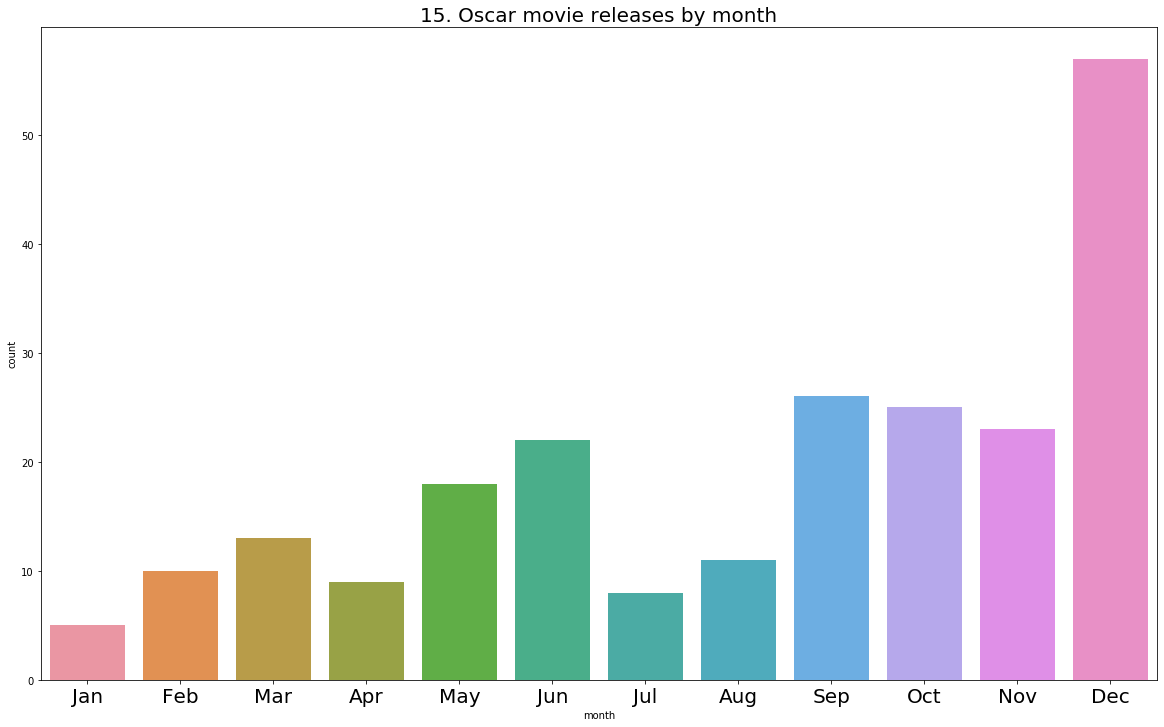

In [24]:
plt.figure(figsize=(20,12))
sns.countplot(dataset_oscars['release_date'].dt.month.sort_values())
plt.title("15. Oscar movie releases by month",fontsize=20)
loc, _ = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("month")
plt.show()

Najwięcej filmów oscarowych wydanych zostało w grudniu a najmniej w styczniu i lipcu

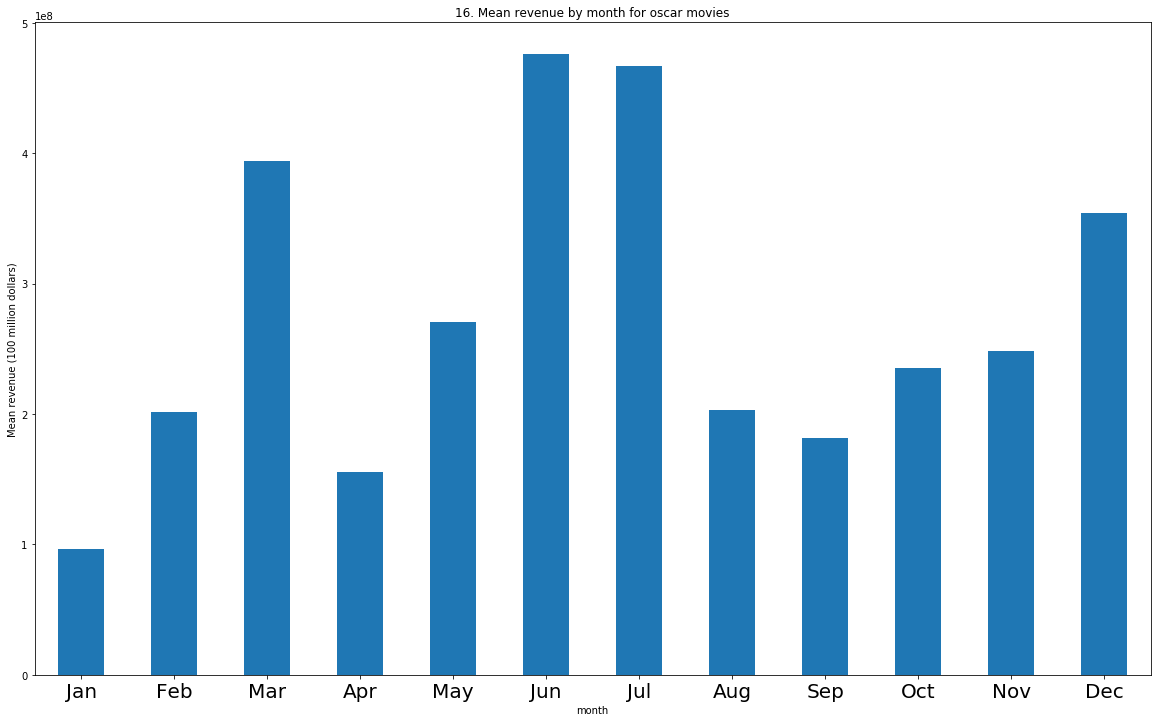

In [25]:
plt.figure(figsize=(20,12))
dataset_oscars.groupby(dataset_oscars["release_date"].dt.month).agg('mean')['revenue'].plot(kind='bar',rot=0)
plt.ylabel('Mean revenue (100 million dollars)')
plt.title("16. Mean revenue by month for oscar movies")
loc, _ = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("month")
plt.show()

Dla filmów oscarowych tak samo średnio najwięcej przychodów przynoszą filmy wydane w czerwcu i lipcu a najmniej filmy wydane w styczniu

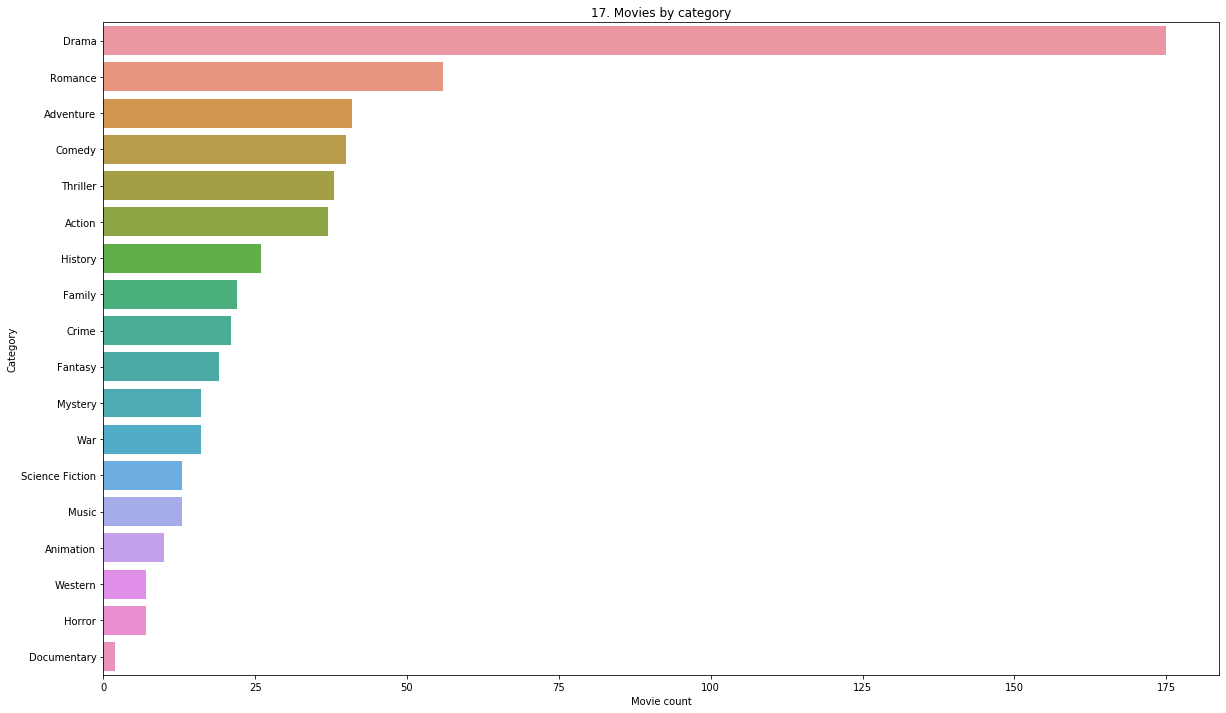

In [26]:
plt.figure(figsize=(20,12))
genre=dataset_oscars['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in genre for i in j]).most_common(20)
sns.barplot([val[1] for val in count],[val[0] for val in count])
plt.title("17. Movies by category")
plt.xlabel("Movie count")
plt.ylabel("Category")
plt.show()

Najwięcej nagrodzonych zostało dramatów a najmniej filmów dokumentalnych

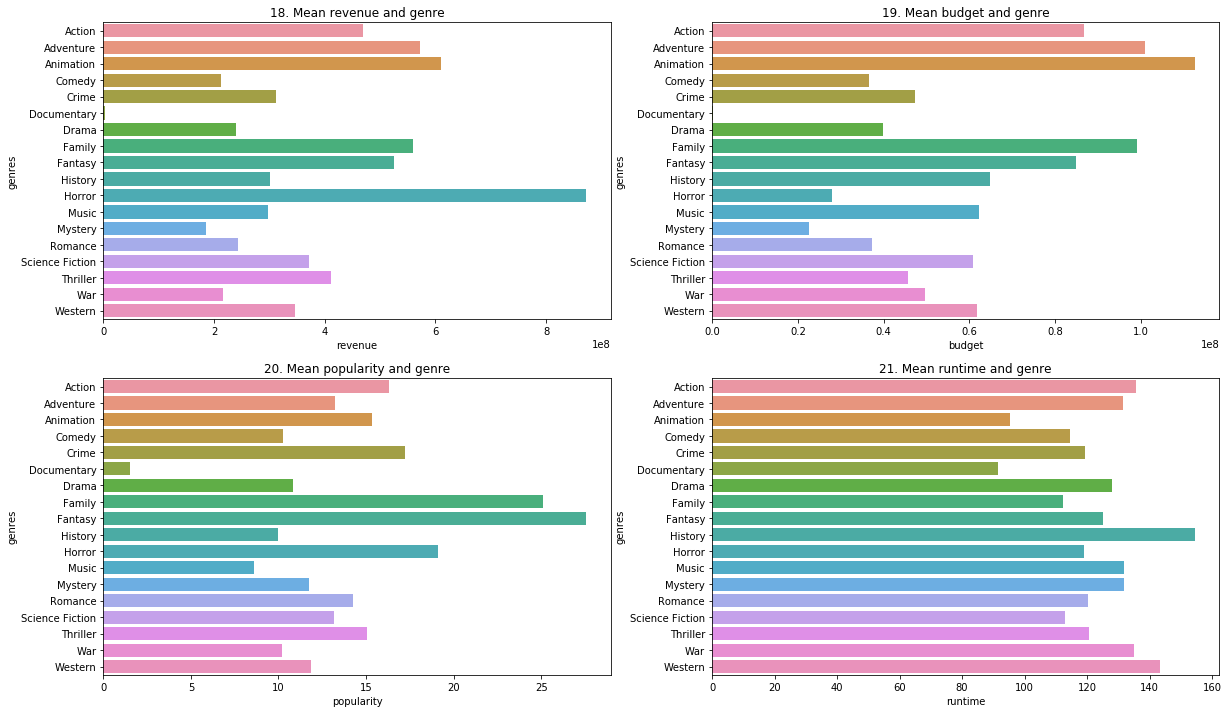

In [27]:
genres = dataset_oscars.explode("genres").reset_index(drop=True)
genres = genres[genres.genres.notnull()]
genres['genres']=genres.genres.apply(lambda x :x['name'])
genres=genres.groupby(genres.genres).agg('mean')
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plt.title("18. Mean revenue and genre")
sns.barplot(genres['revenue'],genres.index)

plt.subplot(2,2,2)
plt.title("19. Mean budget and genre")
sns.barplot(genres['budget'],genres.index)

plt.subplot(2,2,3)
plt.title("20. Mean popularity and genre")
sns.barplot(genres['popularity'],genres.index)

plt.subplot(2,2,4)
plt.title("21. Mean runtime and genre")
sns.barplot(genres['runtime'],genres.index)
plt.show()

Średnie największe przychody z filmów oscarowych przynoszą horrory przy stosunkowo niskich budżetach. 

Średnie największe budżety posiadają filmy animowane. 

Średnie najmniejsze przychody przynoszą filmy dokumentalne, posiadają one również średnio najmniejszy budżet.

Średnio największą popularnością cieszą się filmy fantasy a najmniejszą filmy dokumentalne.

Średnio najdłuższe są horrory a najkrótsze filmy dokumentalne.

Średnie największe przychody z filmów oscarowych przynoszą horrory przy stosunkowo niskich budżetach. 

Średnie największe budżety posiadają filmy animowane. 

Średnie najmniejsze przychody przynoszą filmy dokumentalne, posiadają one również średnio najmniejszy budżet.

Średnio największą popularnością cieszą się filmy fantasy a najmniejszą filmy dokumentalne.

Średnio najdłuższe są horrory a najkrótsze filmy dokumentalne.

Najwięcej nagrodzonych zostało dramatów a najmniej filmów dokumentalnych

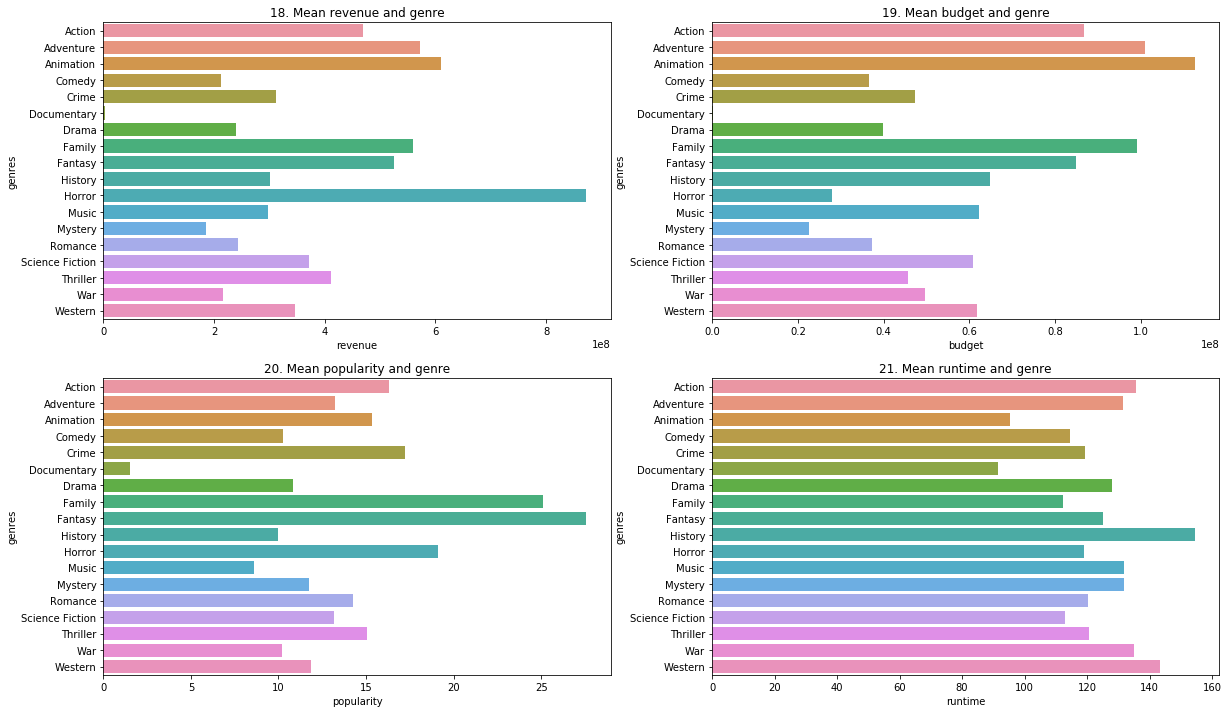

In [28]:
genres = dataset_oscars.explode("genres").reset_index(drop=True)
genres = genres[genres.genres.notnull()]
genres['genres']=genres.genres.apply(lambda x :x['name'])
genres_mean=genres.groupby(genres.genres).agg('mean')
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plt.title("18. Mean revenue and genre")
sns.barplot(genres_mean['revenue'], genres_mean.index)

plt.subplot(2,2,2)
plt.title("19. Mean budget and genre")
sns.barplot(genres_mean['budget'], genres_mean.index)

plt.subplot(2,2,3)
plt.title("20. Mean popularity and genre")
sns.barplot(genres_mean['popularity'], genres_mean.index)

plt.subplot(2,2,4)
plt.title("21. Mean runtime and genre")
sns.barplot(genres_mean['runtime'], genres_mean.index)
plt.show()

Średnie największe przychody z filmów oscarowych przynoszą horrory przy stosunkowo niskich budżetach. 

Średnie największe budżety posiadają filmy animowane. 

Średnie najmniejsze przychody przynoszą filmy dokumentalne, posiadają one również średnio najmniejszy budżet.

Średnio największą popularnością cieszą się filmy fantasy a najmniejszą filmy dokumentalne.

Średnio najdłuższe są horrory a najkrótsze filmy dokumentalne.

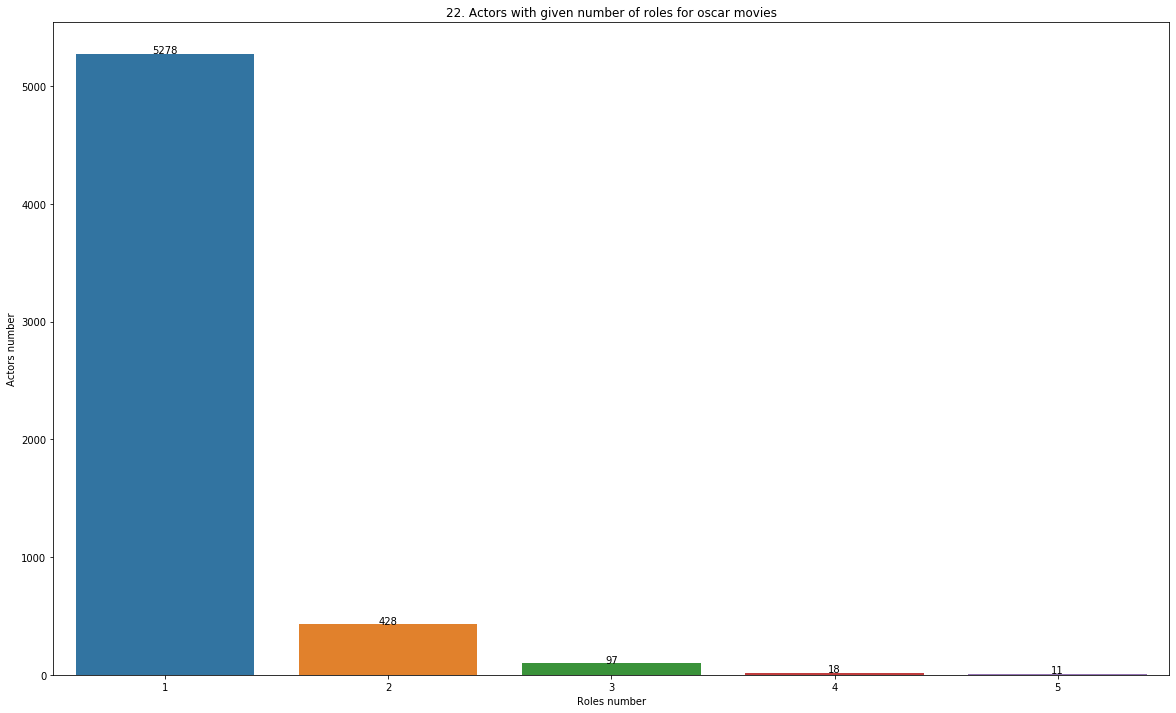

In [29]:
# number of actors with concrette role number for oscar movies
actorMovieDataset = oscar_movies[['title','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
actorMovieDataset = actorMovieDataset.explode('cast').reset_index(drop=True)
actorMovieDataset = actorMovieDataset.groupby(['cast']).size().reset_index(name='count').sort_values('count', ascending=False)
actorMovieRolesDataset = actorMovieDataset.groupby(['count']).size().reset_index(name='actors_with_given_role_number')
x = actorMovieRolesDataset['count']
y = actorMovieRolesDataset['actors_with_given_role_number']

plt.figure(figsize=(20,12))
#plt.subplot(2,1,1)
snbp = sns.barplot(x='count',y='actors_with_given_role_number',data=actorMovieRolesDataset)
show_values_on_bars(snbp, "v", 0.5)
plt.title("22. Actors with given number of roles for oscar movies")
plt.xlabel("Roles number")
plt.ylabel("Actors number")
plt.show()

Dominujący są aktorzy, którzy zagrali w jednym filmie. Tendencja pomiedzy filmami oskarowymi i zwykłymi jest zachowana. W filamch oskarowych mamy dużą różnorodnośc aktorów.



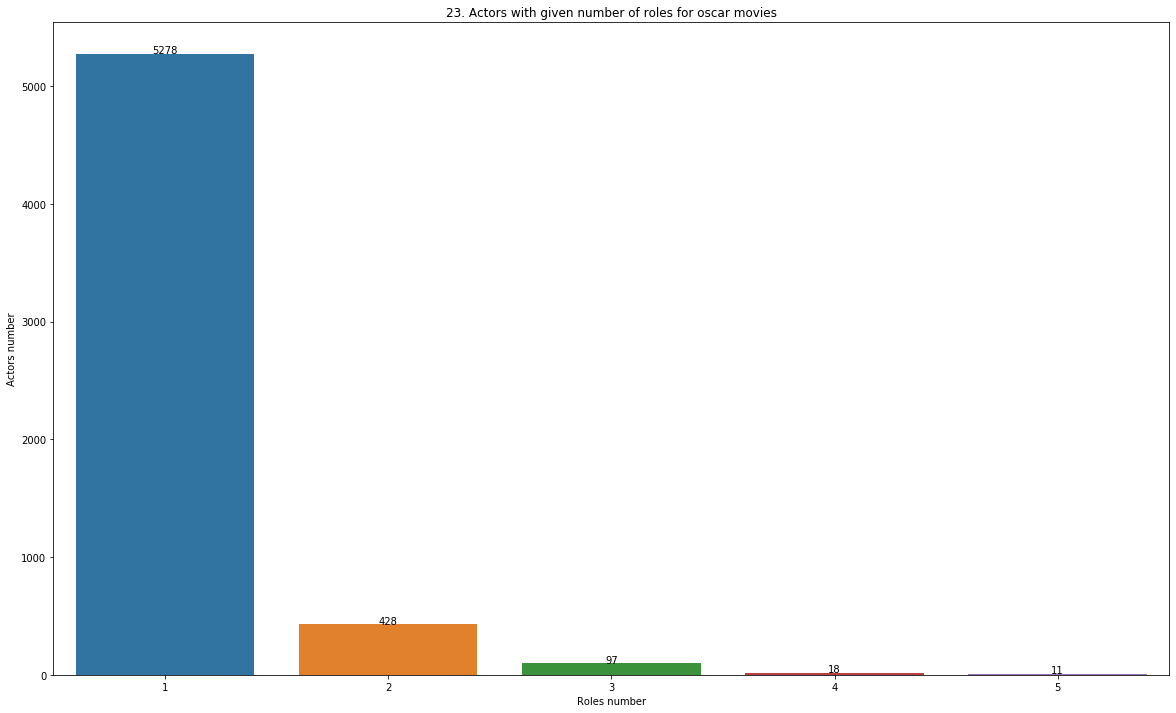

In [30]:
# number of actors with concrette role number for oscar movies
actorMovieDataset = oscar_movies[['title','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
actorMovieDataset = actorMovieDataset.explode('cast').reset_index(drop=True)
actorMovieDataset = actorMovieDataset.groupby(['cast']).size().reset_index(name='count').sort_values('count', ascending=False)
actorMovieRolesDataset = actorMovieDataset.groupby(['count']).size().reset_index(name='actors_with_given_role_number')
x = actorMovieRolesDataset['count']
y = actorMovieRolesDataset['actors_with_given_role_number']

plt.figure(figsize=(20,12))
#plt.subplot(2,1,1)
snbp = sns.barplot(x='count',y='actors_with_given_role_number',data=actorMovieRolesDataset)
show_values_on_bars(snbp, "v", 0.5)
plt.title("23. Actors with given number of roles for oscar movies")
plt.xlabel("Roles number")
plt.ylabel("Actors number")
plt.show()

Dominujący są aktorzy, którzy zagrali w jednym filmie. Tendencja pomiedzy filmami oskarowymi i zwykłymi jest zachowana. W filamch oskarowych mamy dużą różnorodnośc aktorów.

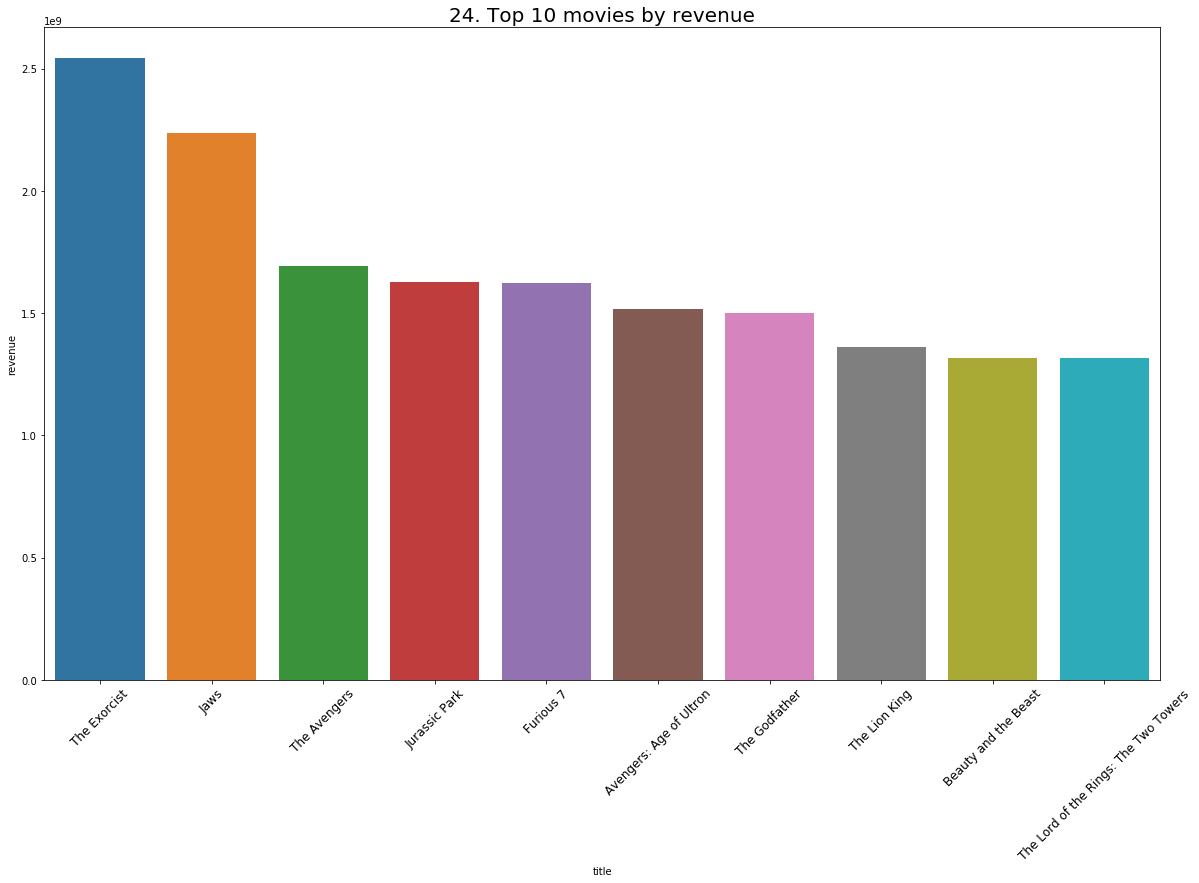

In [31]:
plt.figure(figsize=(20,12))
r = dataset.sort_values('revenue', ascending=False).head(10)
sns.barplot(r["title"], r["revenue"])
plt.xticks(fontsize=12,rotation=45)
plt.title("24. Top 10 movies by revenue",fontsize=20)
plt.show()

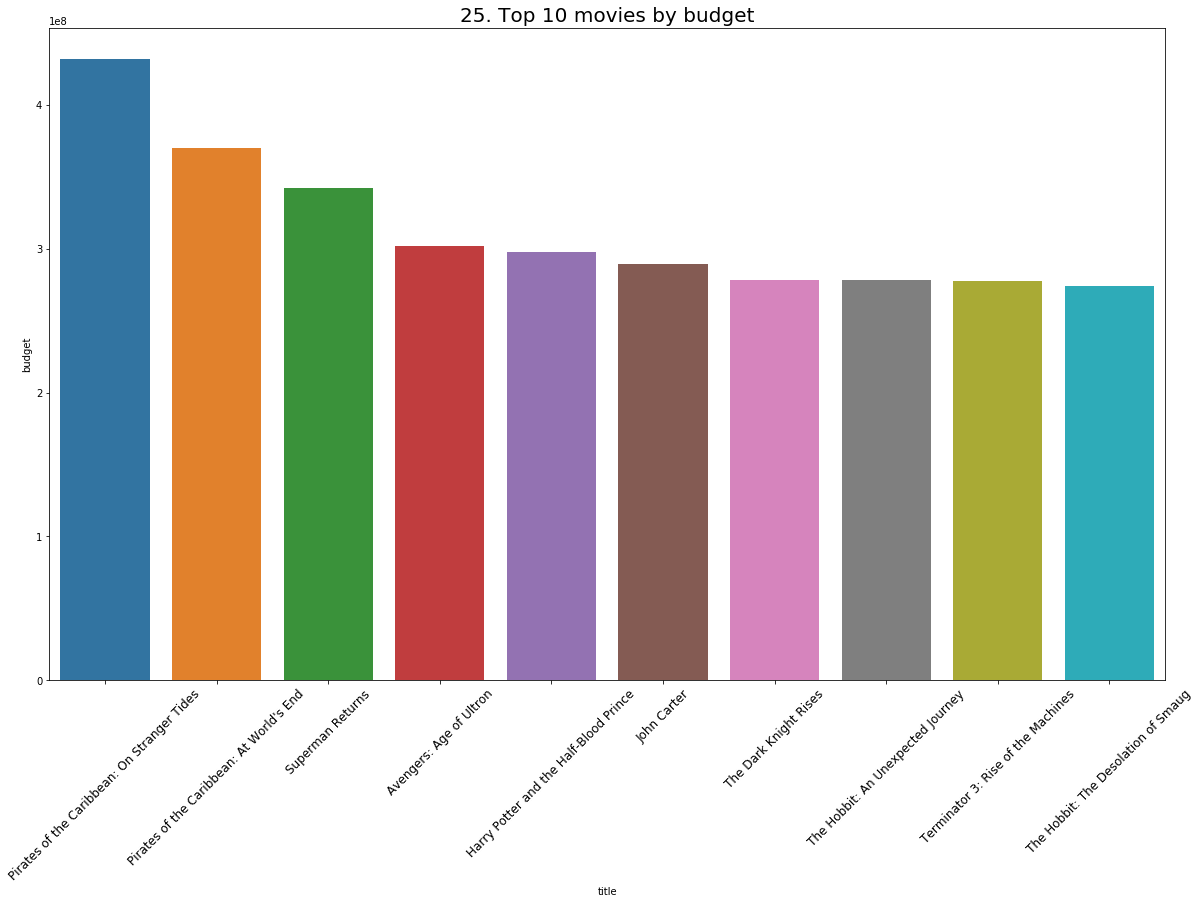

In [32]:
r = dataset.sort_values('budget', ascending=False).head(10)
plt.figure(figsize=(20,12))
sns.barplot(r["title"], r["budget"])
plt.xticks(fontsize=12,rotation=45)
plt.title("25. Top 10 movies by budget",fontsize=20)
plt.show()

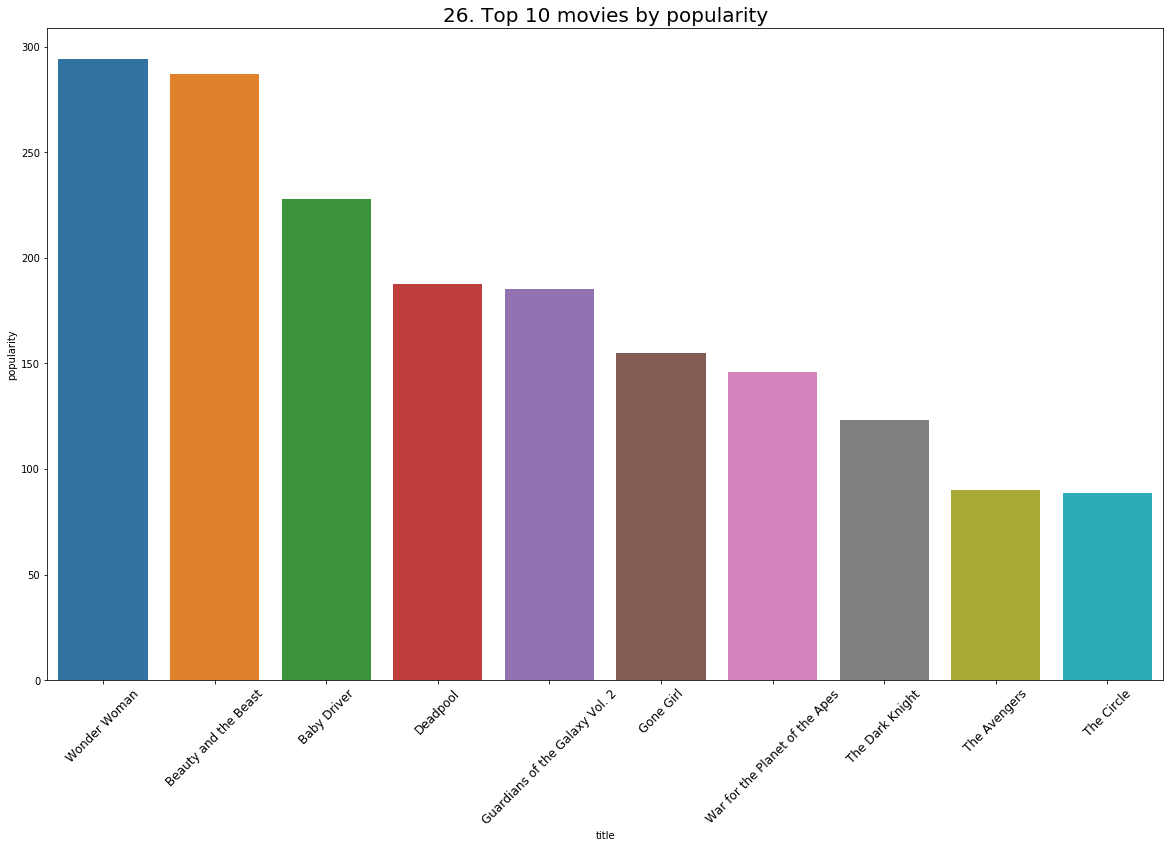

In [33]:
r = dataset.sort_values('popularity', ascending=False).head(10)
plt.figure(figsize=(20,12))
sns.barplot(r["title"], r["popularity"])
plt.xticks(fontsize=12,rotation=45)
plt.title("26. Top 10 movies by popularity",fontsize=20)
plt.show()

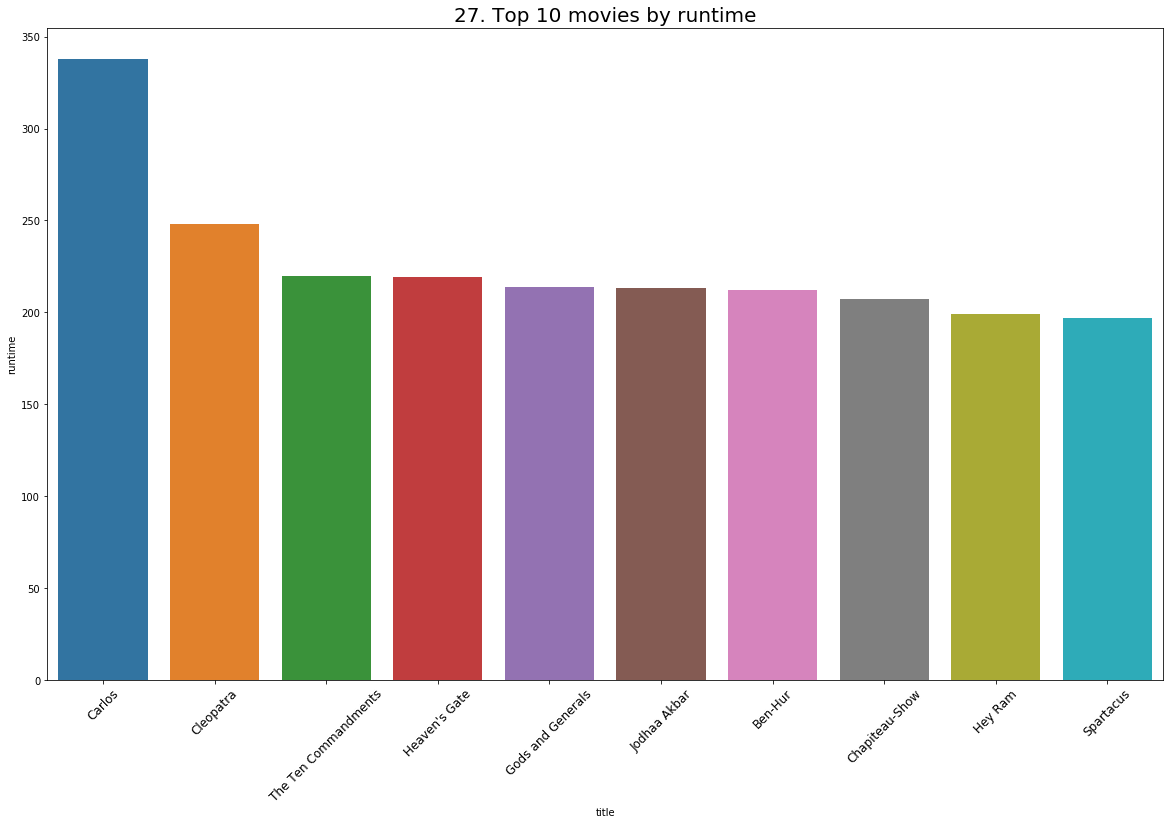

In [34]:
r = dataset.sort_values('runtime', ascending=False).head(10)
plt.figure(figsize=(20,12))
sns.barplot(r["title"], r["runtime"])
plt.xticks(fontsize=12,rotation=45)
plt.title("27. Top 10 movies by runtime",fontsize=20)
plt.show()

In [35]:
# Movies with highest revenue in each genre
genres.sort_values('revenue', ascending=False).groupby(genres.genres, sort=False).head(1)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
452,"[{'id': 12263, 'name': 'The Exorcist Collectio...",46064324,Drama,http://theexorcist.warnerbros.com/,tt0070047,en,The Exorcist,12-year-old Regan MacNeil begins to adapt an e...,12.137595,/mBLSuXTAJExUFdqYFgZro7Y9ZDG.jpg,...,1973-12-26,122.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,Something almost beyond comprehension is happe...,the exorcist,"[{'id': 2626, 'name': 'exorcism'}, {'id': 3649...","[{'cast_id': 14, 'character': 'Regan', 'credit...","[{'credit_id': '52fe4508c3a36847f80b865d', 'de...",2541058673
453,"[{'id': 12263, 'name': 'The Exorcist Collectio...",46064324,Horror,http://theexorcist.warnerbros.com/,tt0070047,en,The Exorcist,12-year-old Regan MacNeil begins to adapt an e...,12.137595,/mBLSuXTAJExUFdqYFgZro7Y9ZDG.jpg,...,1973-12-26,122.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,Something almost beyond comprehension is happe...,the exorcist,"[{'id': 2626, 'name': 'exorcism'}, {'id': 3649...","[{'cast_id': 14, 'character': 'Regan', 'credit...","[{'credit_id': '52fe4508c3a36847f80b865d', 'de...",2541058673
454,"[{'id': 12263, 'name': 'The Exorcist Collectio...",46064324,Thriller,http://theexorcist.warnerbros.com/,tt0070047,en,The Exorcist,12-year-old Regan MacNeil begins to adapt an e...,12.137595,/mBLSuXTAJExUFdqYFgZro7Y9ZDG.jpg,...,1973-12-26,122.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,Something almost beyond comprehension is happe...,the exorcist,"[{'id': 2626, 'name': 'exorcism'}, {'id': 3649...","[{'cast_id': 14, 'character': 'Regan', 'credit...","[{'credit_id': '52fe4508c3a36847f80b865d', 'de...",2541058673
33,"[{'id': 2366, 'name': 'The Jaws Collection', '...",33263921,Adventure,http://www.jaws25.com/,tt0073195,en,Jaws,An insatiable great white shark terrorizes the...,19.726114,/l1yltvzILaZcx2jYvc5sEMkM7Eh.jpg,...,1975-06-18,124.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Don't go in the water.,jaws,"[{'id': 1495, 'name': 'fishing'}, {'id': 1913,...","[{'cast_id': 15, 'character': 'Police Chief Ma...","[{'credit_id': '52fe4255c3a36847f801601f', 'de...",2236542559
327,"[{'id': 328, 'name': 'Jurassic Park Collection...",111462913,Science Fiction,http://www.jurassicpark.com/,tt0107290,en,Jurassic Park,A wealthy entrepreneur secretly creates a them...,8.863776,/c414cDeQ9b6qLPLeKmiJuLDUREJ.jpg,...,1993-06-11,127.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,An adventure 65 million years in the making.,jurassic park,"[{'id': 911, 'name': 'exotic island'}, {'id': ...","[{'cast_id': 4, 'character': 'Dr. Alan Grant',...","[{'credit_id': '52fe4238c3a36847f800d291', 'de...",1627889312
210,"[{'id': 230, 'name': 'The Godfather Collection...",36697177,Crime,http://www.thegodfather.com/,tt0068646,en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",41.109264,/rPdtLWNsZmAtoZl9PK7S2wE3qiS.jpg,...,1972-03-14,175.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,An offer you can't refuse.,the godfather,"[{'id': 131, 'name': 'italy'}, {'id': 699, 'na...","[{'cast_id': 5, 'character': 'Don Vito Corleon...","[{'credit_id': '52fe422bc3a36847f80093db', 'de...",1498874244
63,"[{'id': 94032, 'name': 'The Lion King Collecti...",77628643,Family,http://movies.disney.com/the-lion-king,tt0110357,en,The Lion King,A young lion cub named Simba can't wait to be ...,21.605761,/bKPtXn9n4M4s8vvZrbw40mYsefB.jpg,...,1994-06-23,89.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Life's greatest adventure is finding your plac...,the lion king,"[{'id': 2143, 'name': 'loss of parents'}, {'id...","[{'cast_id': 8, 'character': 'Young Simba (voi...","[{'credit_id': '59161a6bc3a36842690252b9', 'de...",1359780888
64,"[{'id': 94032, 'name': 'The Lion King Collecti...",77628643,Animation,http://movies.disney.com/the-lion-king,tt01

In [36]:
# Movies with highest budget in each genre
genres.sort_values('budget', ascending=False).groupby(genres.genres, sort=False).head(1)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
385,{},270972857,Drama,NaN,tt0360717,en,King Kong,"In 1933 New York, an overly ambitious movie pr...",19.761164,/iQYMVoI9QE2wQCOSrxhiBYd4v0w.jpg,...,2005-12-14,187.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The eighth wonder of the world.,king kong,"[{'id': 774, 'name': 'film business'}, {'id': ...","[{'cast_id': 5, 'character': 'Ann Darrow', 'cr...","[{'credit_id': '52fe422ec3a36847f800a1d7', 'de...",719976190
386,{},270972857,Action,NaN,tt0360717,en,King Kong,"In 1933 New York, an overly ambitious movie pr...",19.761164,/iQYMVoI9QE2wQCOSrxhiBYd4v0w.jpg,...,2005-12-14,187.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The eighth wonder of the world.,king kong,"[{'id': 774, 'name': 'film business'}, {'id': ...","[{'cast_id': 5, 'character': 'Ann Darrow', 'cr...","[{'credit_id': '52fe422ec3a36847f800a1d7', 'de...",719976190
384,{},270972857,Adventure,NaN,tt0360717,en,King Kong,"In 1933 New York, an overly ambitious movie pr...",19.761164,/iQYMVoI9QE2wQCOSrxhiBYd4v0w.jpg,...,2005-12-14,187.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The eighth wonder of the world.,king kong,"[{'id': 774, 'name': 'film business'}, {'id': ...","[{'cast_id': 5, 'character': 'Ann Darrow', 'cr...","[{'credit_id': '52fe422ec3a36847f800a1d7', 'de...",719976190
513,"[{'id': 645, 'name': 'James Bond Collection', ...",264267816,Crime,http://www.sonypictures.com/movies/spectre/,tt2379713,en,Spectre,A cryptic message from Bond‚Äôs past sends him...,24.926577,/hE24GYddaxB9MVZl1CaiI86M3kp.jpg,...,2015-10-26,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,spectre,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...","[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '5751eed59251416b60000637', 'de...",949934513
370,{},259959724,Romance,NaN,tt0056937,en,Cleopatra,Historical epic. The triumphs and tragedy of t...,8.591238,/bj7rUGUewofA9cpHt1h36gvDFfy.jpg,...,1963-06-12,248.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The motion picture the world has been waiting ...,cleopatra,"[{'id': 5049, 'name': 'ancient rome'}, {'id': ...","[{'cast_id': 2, 'character': 'Cleopatra', 'cre...","[{'credit_id': '52fe4493c3a36847f809de91', 'de...",593191078
369,{},259959724,History,NaN,tt0056937,en,Cleopatra,Historical epic. The triumphs and tragedy of t...,8.591238,/bj7rUGUewofA9cpHt1h36gvDFfy.jpg,...,1963-06-12,248.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The motion picture the world has been waiting ...,cleopatra,"[{'id': 5049, 'name': 'ancient rome'}, {'id': ...","[{'cast_id': 2, 'character': 'Cleopatra', 'cre...","[{'credit_id': '52fe4493c3a36847f809de91', 'de...",593191078
205,"[{'id': 420, 'name': 'The Chronicles of Narnia...",235628571,Family,NaN,tt0363771,en,"The Chronicles of Narnia: The Lion, the Witch ...","Siblings Lucy, Edmund, Susan and Peter step th...",18.135420,/l8RKDgjl9co0IgFZblxhtIOi5Uj.jpg,...,2005-12-07,143.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Evil Has Reigned For 100 Years...,"the chronicles of narnia: the lion, the witch ...","[{'id': 83, 'name': 'saving the world'}, {'id'...","[{'cast_id': 5, 'character': 'Peter Pevensie',...","[{'credit_id': '52fe4240c3a36847f800fd4f', 'de...",980223964
206,"[{'id': 420, 'name': 'The Chronicles of Narnia...",235628571,Fantasy,NaN,tt0363771,en,"The Chronicles of Narnia: The Lion, the Witch ...","Siblings Lucy, Edmund, Susan and Peter step th...",18.135420,/l8RKDgjl9co0IgFZblxhtIOi5Uj.jpg,...,2005-12-07,143.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Evil Has Reigned For 100 Years...,"the chronicles of narnia: the lion, the witch ...","[{'id': 83, 'name': 'saving the world'}, {'id'...","[{'cast_id': 5, 'character': 'Peter Pevensie',...","[{'credit_id':

In [37]:
# Movies with highest popularity in each genre
genres.sort_values('popularity', ascending=False).groupby(genres.genres, sort=False).head(1)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
152,{},166877937,Romance,http://movies.disney.com/beauty-and-the-beast-...,tt2771200,en,Beauty and the Beast,A live-action adaptation of Disney's version o...,287.253654,/tWqifoYuwLETmmasnGHO7xBjEtt.jpg,...,2017-03-16,129.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Be our guest.,beauty and the beast,"[{'id': 254, 'name': 'france'}, {'id': 2343, '...","[{'cast_id': 174, 'character': 'Belle', 'credi...","[{'credit_id': '551879bec3a3681f840004eb', 'de...",1317174168
150,{},166877937,Family,http://movies.disney.com/beauty-and-the-beast-...,tt2771200,en,Beauty and the Beast,A live-action adaptation of Disney's version o...,287.253654,/tWqifoYuwLETmmasnGHO7xBjEtt.jpg,...,2017-03-16,129.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Be our guest.,beauty and the beast,"[{'id': 254, 'name': 'france'}, {'id': 2343, '...","[{'cast_id': 174, 'character': 'Belle', 'credi...","[{'credit_id': '551879bec3a3681f840004eb', 'de...",1317174168
151,{},166877937,Fantasy,http://movies.disney.com/beauty-and-the-beast-...,tt2771200,en,Beauty and the Beast,A live-action adaptation of Disney's version o...,287.253654,/tWqifoYuwLETmmasnGHO7xBjEtt.jpg,...,2017-03-16,129.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Be our guest.,beauty and the beast,"[{'id': 254, 'name': 'france'}, {'id': 2343, '...","[{'cast_id': 174, 'character': 'Belle', 'credi...","[{'credit_id': '551879bec3a3681f840004eb', 'de...",1317174168
312,"[{'id': 263, 'name': 'The Dark Knight Collecti...",219674342,Crime,http://thedarkknight.warnerbros.com/dvdsite/,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,123.167259,/1hRoyzDtpgMU7Dz4JF22RANzQO7.jpg,...,2008-07-16,152.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Why So Serious?,the dark knight,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...","[{'cast_id': 35, 'character': 'Bruce Wayne / B...","[{'credit_id': '55a0eb4a925141296b0010f8', 'de...",1192841707
311,"[{'id': 263, 'name': 'The Dark Knight Collecti...",219674342,Action,http://thedarkknight.warnerbros.com/dvdsite/,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,123.167259,/1hRoyzDtpgMU7Dz4JF22RANzQO7.jpg,...,2008-07-16,152.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Why So Serious?,the dark knight,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...","[{'cast_id': 35, 'character': 'Bruce Wayne / B...","[{'credit_id': '55a0eb4a925141296b0010f8', 'de...",1192841707
310,"[{'id': 263, 'name': 'The Dark Knight Collecti...",219674342,Drama,http://thedarkknight.warnerbros.com/dvdsite/,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,123.167259,/1hRoyzDtpgMU7Dz4JF22RANzQO7.jpg,...,2008-07-16,152.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Why So Serious?,the dark knight,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...","[{'cast_id': 35, 'character': 'Bruce Wayne / B...","[{'credit_id': '55a0eb4a925141296b0010f8', 'de...",1192841707
313,"[{'id': 263, 'name': 'The Dark Knight Collecti...",219674342,Thriller,http://thedarkknight.warnerbros.com/dvdsite/,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,123.167259,/1hRoyzDtpgMU7Dz4JF22RANzQO7.jpg,...,2008-07-16,152.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Why So Serious?,the dark knight,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...","[{'cast_id': 35, 'character': 'Bruce Wayne / B...","[{'credit_id': '55a0eb4a925141296b0010f8', 'de...",1192841707
215,{},31857570,Comedy,NaN,tt0118799,it,La vita è bella,A touching story of an Italian book seller of ...,39.394970,/f7DImXDebOs148U4uPjI61iDvaK.jpg,...,1997-12-20,116.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"An unforgettable fable that proves lov

In [38]:
# Movies with longest runtime in each genre
genres.sort_values('runtime', ascending=False).groupby(genres.genres, sort=False).head(1)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
368,{},259959724,Drama,NaN,tt0056937,en,Cleopatra,Historical epic. The triumphs and tragedy of t...,8.591238,/bj7rUGUewofA9cpHt1h36gvDFfy.jpg,...,1963-06-12,248.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The motion picture the world has been waiting ...,cleopatra,"[{'id': 5049, 'name': 'ancient rome'}, {'id': ...","[{'cast_id': 2, 'character': 'Cleopatra', 'cre...","[{'credit_id': '52fe4493c3a36847f809de91', 'de...",593191078
369,{},259959724,History,NaN,tt0056937,en,Cleopatra,Historical epic. The triumphs and tragedy of t...,8.591238,/bj7rUGUewofA9cpHt1h36gvDFfy.jpg,...,1963-06-12,248.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The motion picture the world has been waiting ...,cleopatra,"[{'id': 5049, 'name': 'ancient rome'}, {'id': ...","[{'cast_id': 2, 'character': 'Cleopatra', 'cre...","[{'credit_id': '52fe4493c3a36847f809de91', 'de...",593191078
370,{},259959724,Romance,NaN,tt0056937,en,Cleopatra,Historical epic. The triumphs and tragedy of t...,8.591238,/bj7rUGUewofA9cpHt1h36gvDFfy.jpg,...,1963-06-12,248.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The motion picture the world has been waiting ...,cleopatra,"[{'id': 5049, 'name': 'ancient rome'}, {'id': ...","[{'cast_id': 2, 'character': 'Cleopatra', 'cre...","[{'credit_id': '52fe4493c3a36847f809de91', 'de...",593191078
126,{},131781958,Adventure,NaN,tt0052618,en,Ben-Hur,Ben-Hur is a 1959 epic film directed by Willia...,14.319743,/syPMBvvZsADTTRu3UKuxO1Wflq.jpg,...,1959-12-26,212.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The entertainment experience of a lifetime.,ben-hur,"[{'id': 3035, 'name': 'roman'}, {'id': 3071, '...","[{'cast_id': 20, 'character': 'Judah Ben-Hur',...","[{'credit_id': '52fe4266c3a36847f801b99f', 'de...",1290584649
125,{},131781958,Action,NaN,tt0052618,en,Ben-Hur,Ben-Hur is a 1959 epic film directed by Willia...,14.319743,/syPMBvvZsADTTRu3UKuxO1Wflq.jpg,...,1959-12-26,212.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The entertainment experience of a lifetime.,ben-hur,"[{'id': 3035, 'name': 'roman'}, {'id': 3071, '...","[{'cast_id': 20, 'character': 'Judah Ben-Hur',...","[{'credit_id': '52fe4266c3a36847f801b99f', 'de...",1290584649
122,{},0,Fantasy,http://www.orionpictures.com/view/movie/633/Fa...,tt0083922,sv,Fanny och Alexander,"Through the eyes of ten-year-old Alexander, we...",5.472431,/Tn5IdM6XyCls0XekJk0BYKxpHQ.jpg,...,1982-12-17,188.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,fanny & alexander,"[{'id': 1155, 'name': 'brother sister relation...","[{'cast_id': 3, 'character': 'Oscar Ekdahl', '...","[{'credit_id': '52fe4432c3a36847f8087eb5', 'de...",13170547
124,{},0,Mystery,http://www.orionpictures.com/view/movie/633/Fa...,tt0083922,sv,Fanny och Alexander,"Through the eyes of ten-year-old Alexander, we...",5.472431,/Tn5IdM6XyCls0XekJk0BYKxpHQ.jpg,...,1982-12-17,188.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,fanny & alexander,"[{'id': 1155, 'name': 'brother sister relation...","[{'cast_id': 3, 'character': 'Oscar Ekdahl', '...","[{'credit_id': '52fe4432c3a36847f8087eb5', 'de...",13170547
419,{},58816794,War,NaN,tt0077416,en,The Deer Hunter,A group of working-class friends decides to en...,7.729445,/slNJESItHPqp1CENEJQUPw8d7WE.jpg,...,1978-12-08,183.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,One of the most important and powerful films o...,the deer hunter,"[{'id': 422, 'name': 'vietnam veteran'}, {'id'...","[{'cast_id': 11, 'character': 'Michael Vronsky...","[{'credit_id': '52fe44849251416c7503789f', 'de...",196055981
484,{},43033312,Western,NaN,tt0099348,en,Dances with Wolves,"Wounded Civil War soldier, John Dunbar tries t...",11.654349,/hpmclspug1I8EwKSWhL7pWWltA.jpg,...,1990-11-09,181.0,"[{'iso_63

In [39]:
def plot_itemset(title, result, dataset_size):
    plt.figure(figsize=(20,12))
    sns.barplot([", ".join(list(x)) for x in result["itemsets"]], [x * dataset_size for x in result["support"]])
    plt.xticks(fontsize=12,rotation=45)
    plt.title(title,fontsize=20)
    plt.show()

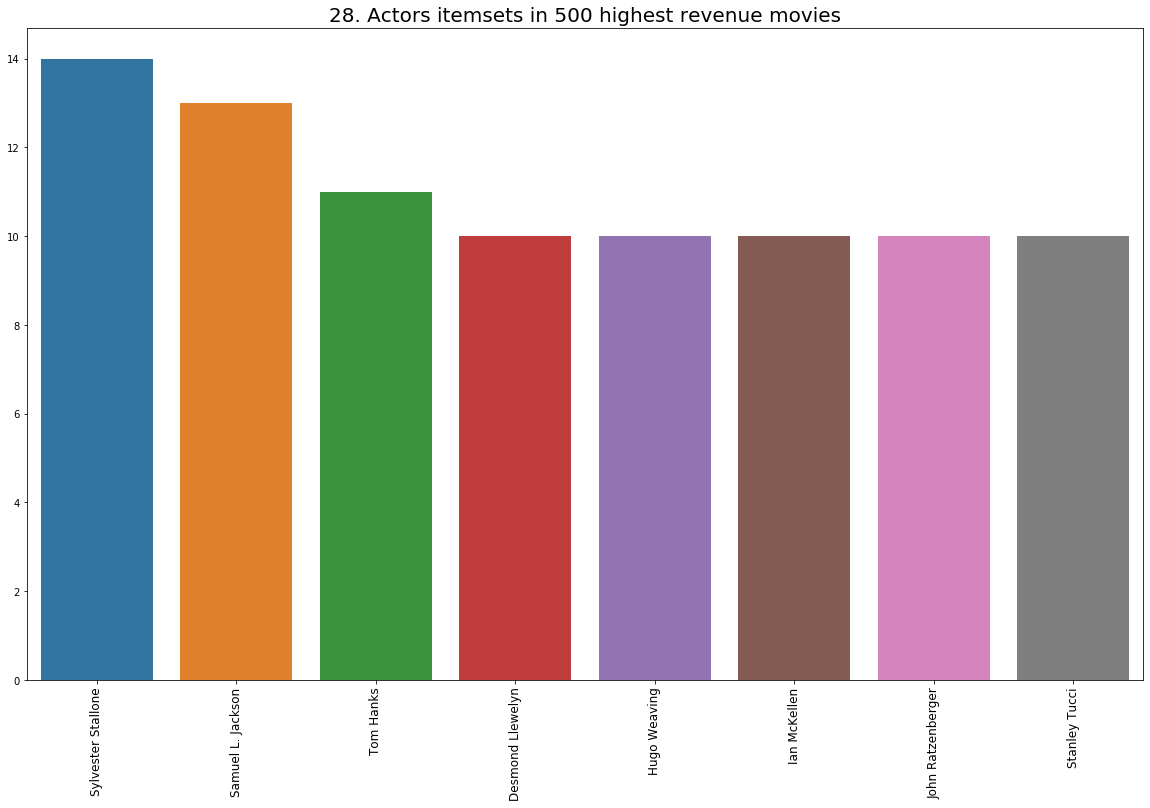

In [6]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
items = 500
r = dataset.sort_values('revenue', ascending=False)["cast"].head(items)
r = r.apply(lambda x: list(map(lambda y: y["name"], x))).reset_index(drop=True).tolist()
te = TransactionEncoder()
te_ary = te.fit(r).transform(r)
df = pd.DataFrame(te_ary, columns=te.columns_)
a = apriori(df, min_support=0.02, use_colnames=True).sort_values('support', ascending=False)
plot_itemset("28. Actors itemsets in " + str(items) + " highest revenue movies", a, items)

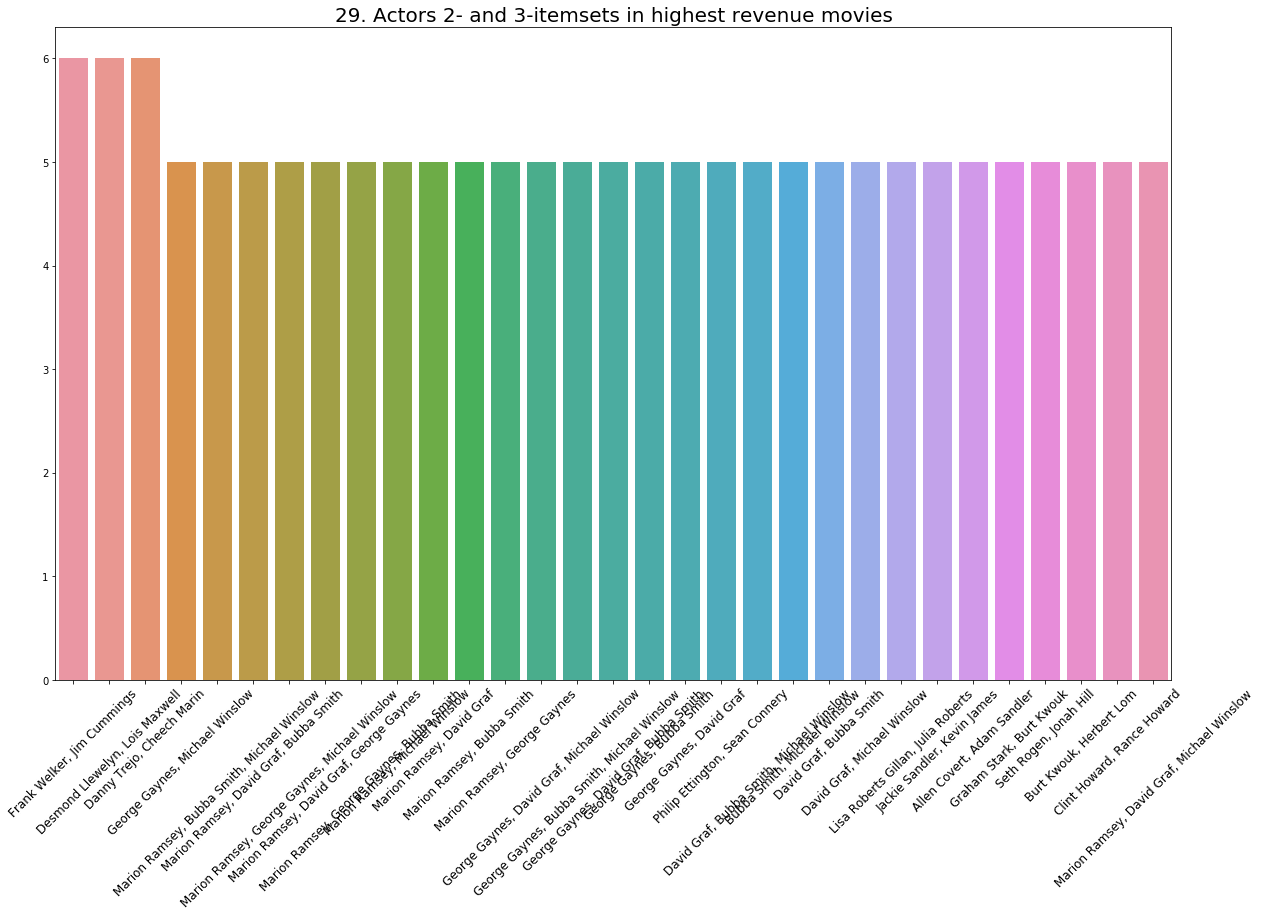

In [41]:
r = dataset.sort_values('revenue', ascending=False)["cast"]
r = r.apply(lambda x: list(map(lambda y: y["name"], x))).reset_index(drop=True).tolist()
te = TransactionEncoder()
te_ary = te.fit(r).transform(r)
df = pd.DataFrame(te_ary, columns=te.columns_)
res = fpgrowth(df, min_support=0.0015, max_len=3, use_colnames=True)
a = res[res["itemsets"].str.len() >= 2].sort_values('support', ascending=False)
plot_itemset("29. Actors 2- and 3-itemsets in highest revenue movies", a, len(dataset))

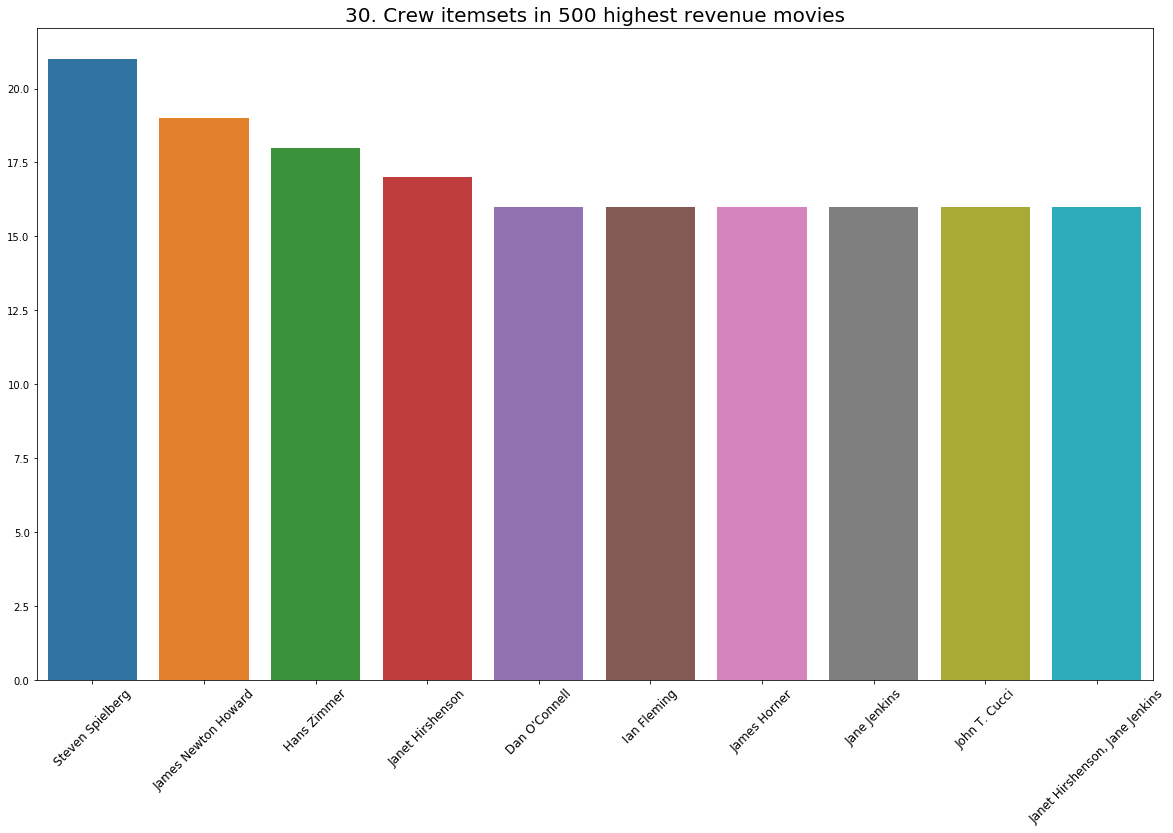

In [42]:
items = 500
r = dataset.sort_values('revenue', ascending=False)["crew"].head(items)
r = r.apply(lambda x: list(map(lambda y: y["name"], x))).reset_index(drop=True).tolist()
te = TransactionEncoder()
te_ary = te.fit(r).transform(r)
df = pd.DataFrame(te_ary, columns=te.columns_)
a = apriori(df, min_support=0.03, use_colnames=True).sort_values('support', ascending=False)
plot_itemset("30. Crew itemsets in " + str(items) + " highest revenue movies", a, items)

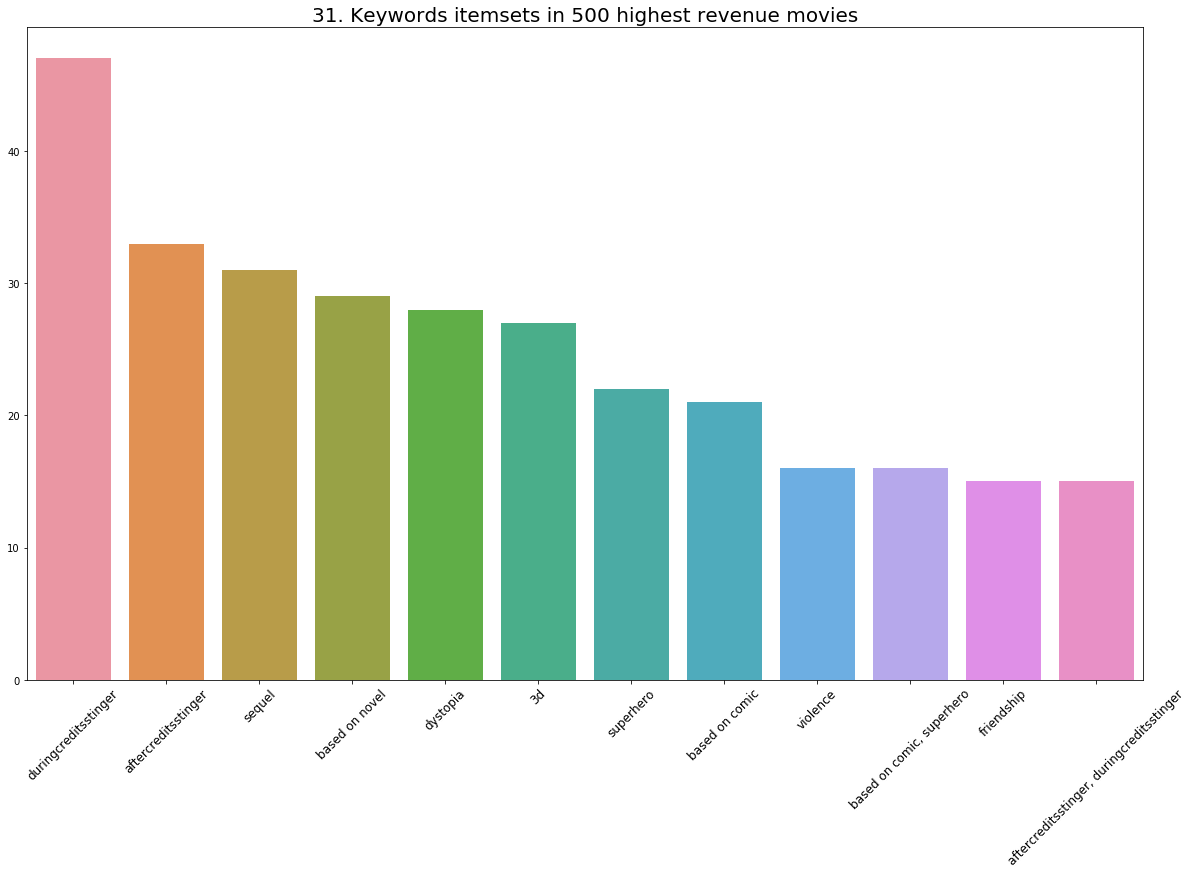

In [43]:
items = 500
r = dataset.sort_values('revenue', ascending=False)["Keywords"].head(items)
r = r.apply(lambda x: list(map(lambda y: y["name"], x))).reset_index(drop=True).tolist()
te = TransactionEncoder()
te_ary = te.fit(r).transform(r)
df = pd.DataFrame(te_ary, columns=te.columns_)
a = apriori(df, min_support=0.03, use_colnames=True).sort_values('support', ascending=False)
plot_itemset("31. Keywords itemsets in " + str(items) + " highest revenue movies", a, items)

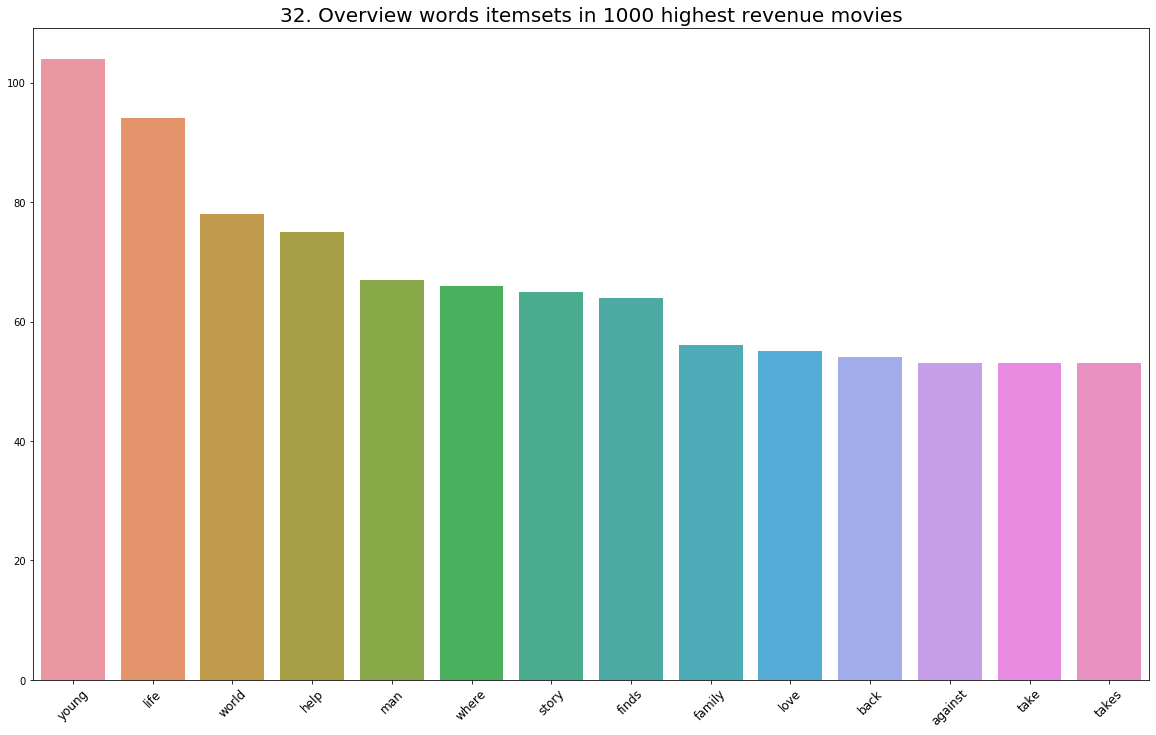

In [46]:
filtered_words = ["of", "in", "a", "an", "to", "the", "this", "have", "been", "about", "only", "which", "them", "was", "while", "not", "will", "two", "can", "all", "get", "and", "is", "his", "no", "no", "now", "new", "gets", "go", "he", "her", "she", "with", "one", "for", "must", "be", "if", "him", "after", "out", "find", "it", "that", "from", "on", "by", "as", "who", "their", "are", "has", "true", "but", "it's", "at", "up", "they", "when", "into"]
items = 1000
r = dataset.sort_values('revenue', ascending=False)["overview"].head(items)
r = r.apply(lambda x: list(filter(lambda y: y.lower() not in filtered_words, x.split(" ")))).tolist()
te = TransactionEncoder()
te_ary = te.fit(r).transform(r)
df = pd.DataFrame(te_ary, columns=te.columns_)
a = apriori(df, min_support=0.05, use_colnames=True).sort_values('support', ascending=False)
plot_itemset("32. Overview words itemsets in " + str(items) + " highest revenue movies", a, items)

In [4]:
# Datasets loading
dataset_original = pd.read_csv('./tmdb-box-office-prediction/train.csv')
dataset = dataset_original

oscars = pd.read_csv('./tmdb-box-office-prediction/the_oscar_award.csv')
oscars_winners = oscars[oscars["winner"] == True].drop(columns=["winner", "year_film", "year_ceremony", "ceremony", "category", "name"])
oscars_winners = oscars_winners[oscars_winners["film"].notnull()]
dataset_lc = dataset.copy()
oscars_winners_lc = oscars_winners.copy()
dataset_lc['title'] = dataset_lc['title'].str.lower()
oscars_winners_lc['film'] = oscars_winners_lc['film'].str.lower()
oscar_movies = pd.merge(left=dataset_lc, right=oscars_winners_lc, left_on='title', right_on='film').drop_duplicates(subset='id')
oscar_movies = oscar_movies.drop(columns=['film'])

dataset = text_to_dict(dataset)
oscar_movies = text_to_dict(oscar_movies)

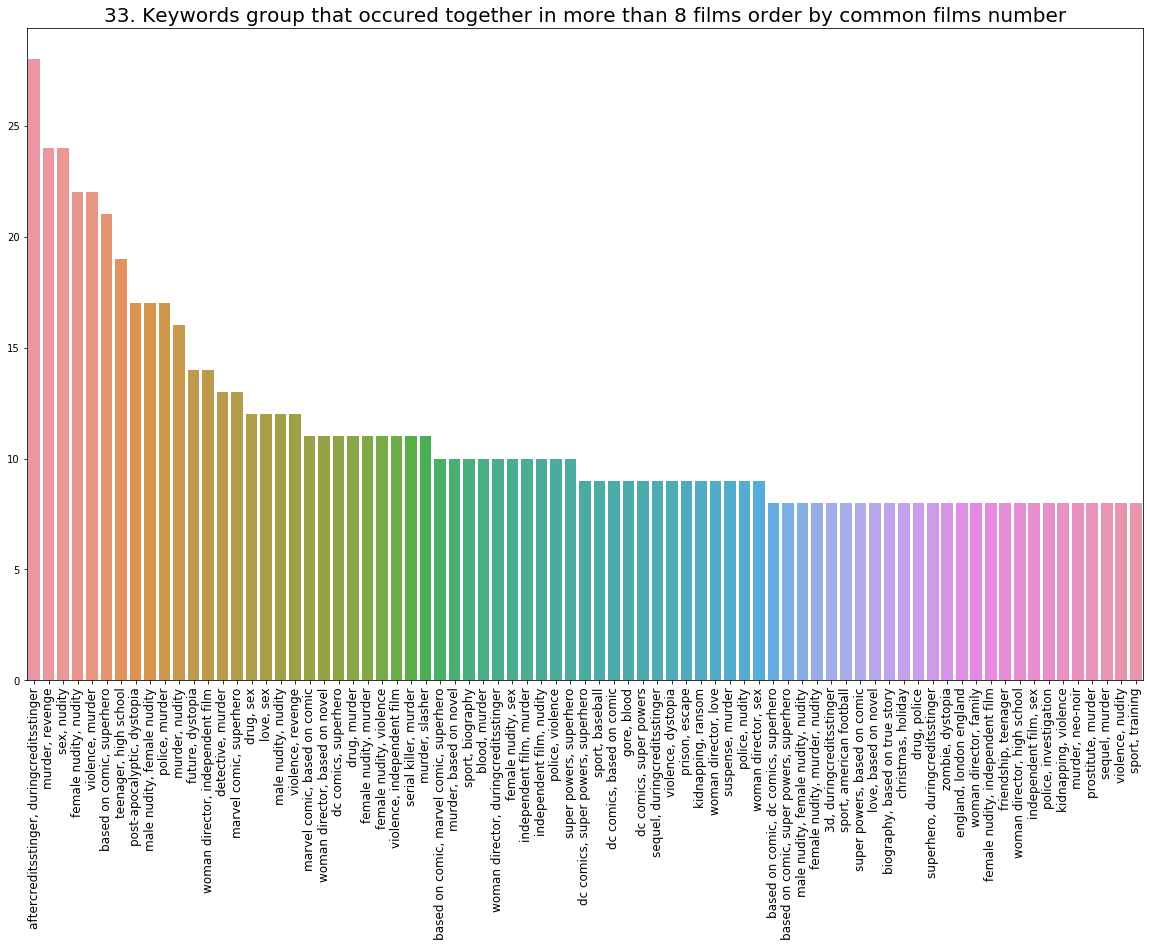

In [9]:
# Keywords clustering for all movies
keywordsMovieDataset = dataset[['id','title','Keywords']].copy()
keywordsMovieDataset['Keywords'] = keywordsMovieDataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
keywordsMovieDataset = keywordsMovieDataset['Keywords']

te = TransactionEncoder()
te_ary = te.fit(keywordsMovieDataset).transform(keywordsMovieDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df,min_support=calculate_support(8,len(df)), max_len=5, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("33. Keywords group that occured together in more than 8 films order by common films number", frequent_itemsets, len(df), rotation=90)

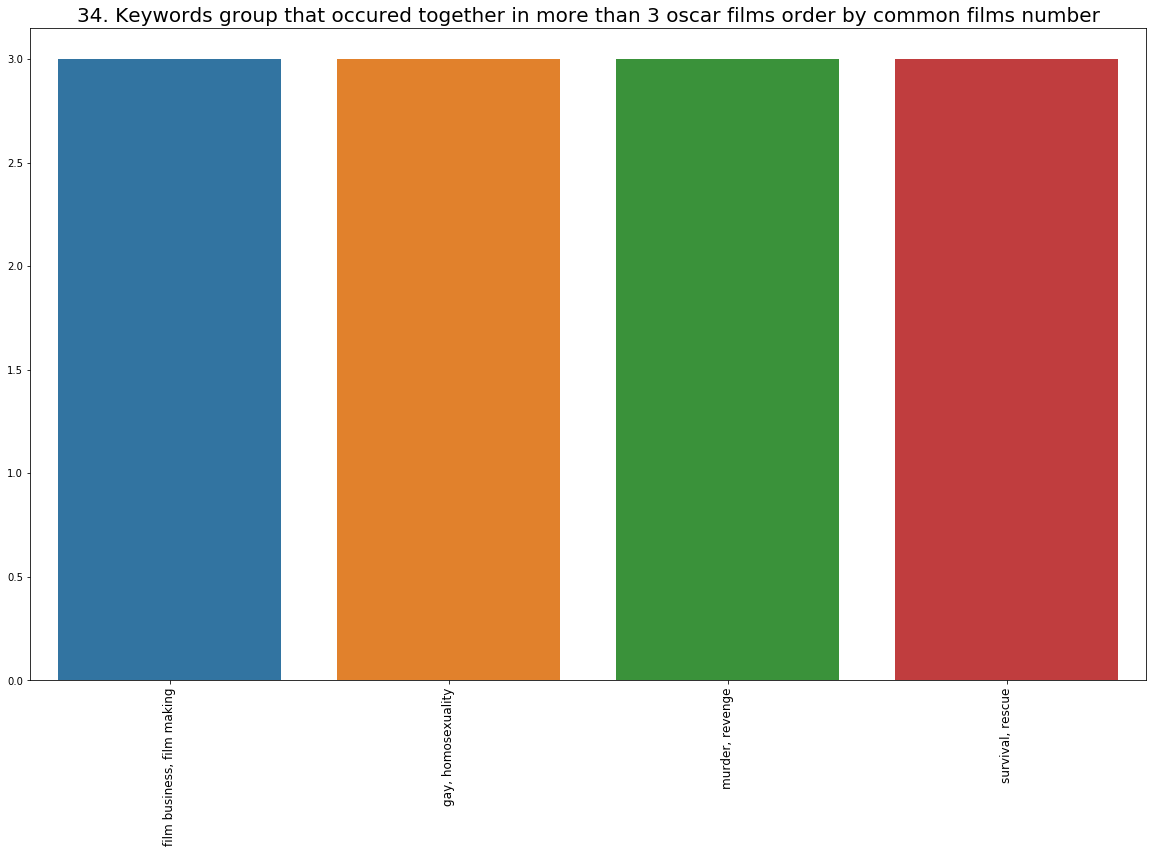

In [10]:
# Keywords clustering for oscar movies
keywordsMovieDataset = oscar_movies[['id','title','Keywords']].copy()
keywordsMovieDataset['Keywords'] = keywordsMovieDataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
keywordsMovieDataset = keywordsMovieDataset['Keywords']

te = TransactionEncoder()
te_ary = te.fit(keywordsMovieDataset).transform(keywordsMovieDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df,min_support=calculate_support(3,len(df)), max_len=5, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("34. Keywords group that occured together in more than 3 oscar films order by common films number", frequent_itemsets, len(df), rotation=90)

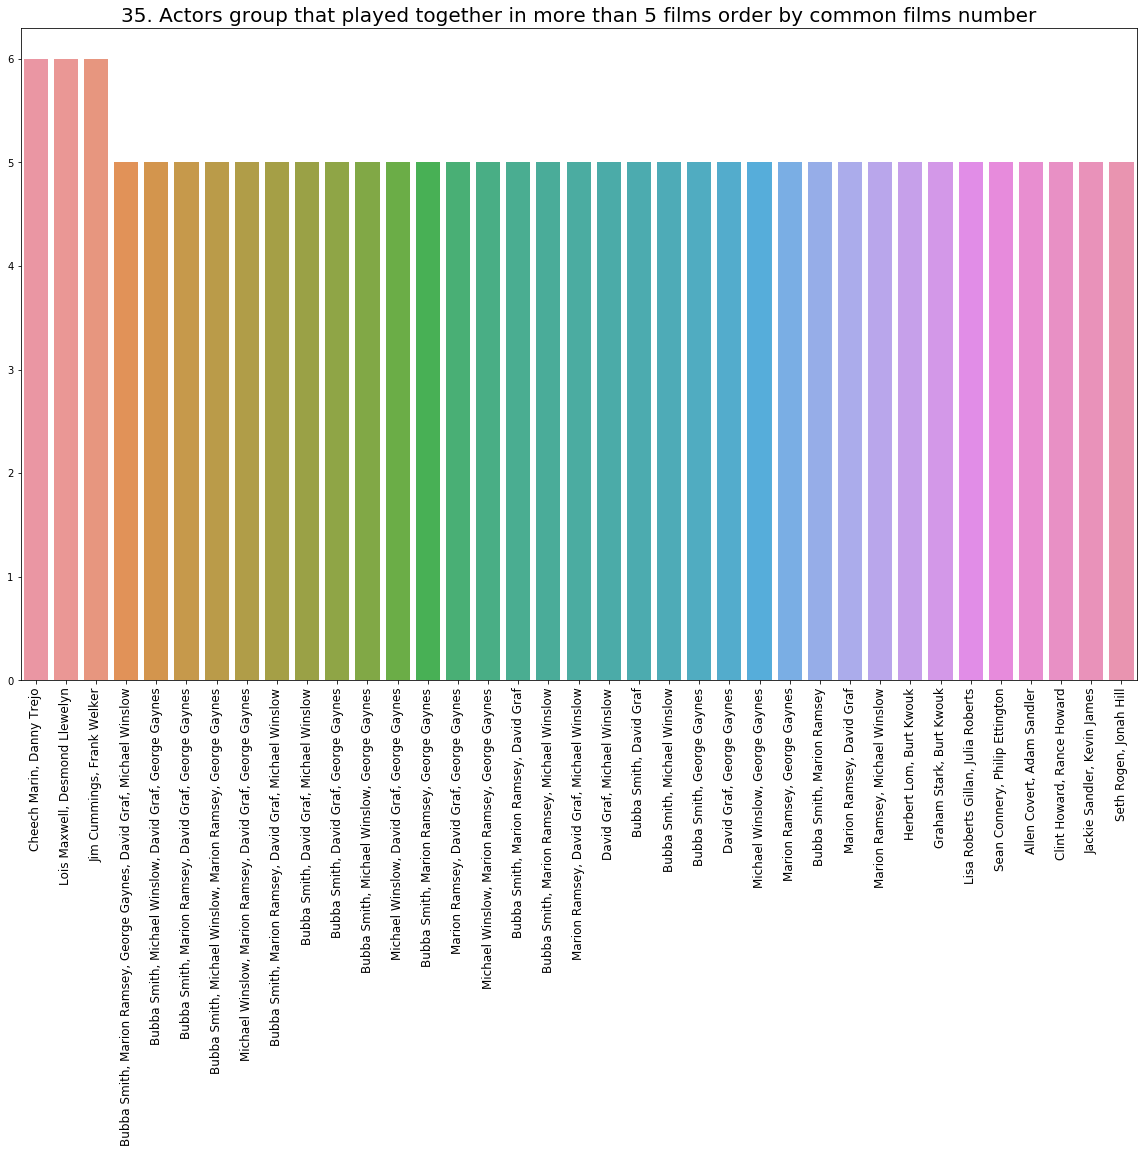

In [12]:
# Actors clustering for all movies
actorMovieDataset = dataset[['id','title','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
actorMovieDataset = actorMovieDataset['cast']

te = TransactionEncoder()
te_ary = te.fit(actorMovieDataset).transform(actorMovieDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df, min_support=calculate_support(5,len(df)), max_len=5,use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("35. Actors group that played together in more than 5 films order by common films number", frequent_itemsets, len(df), rotation=90)

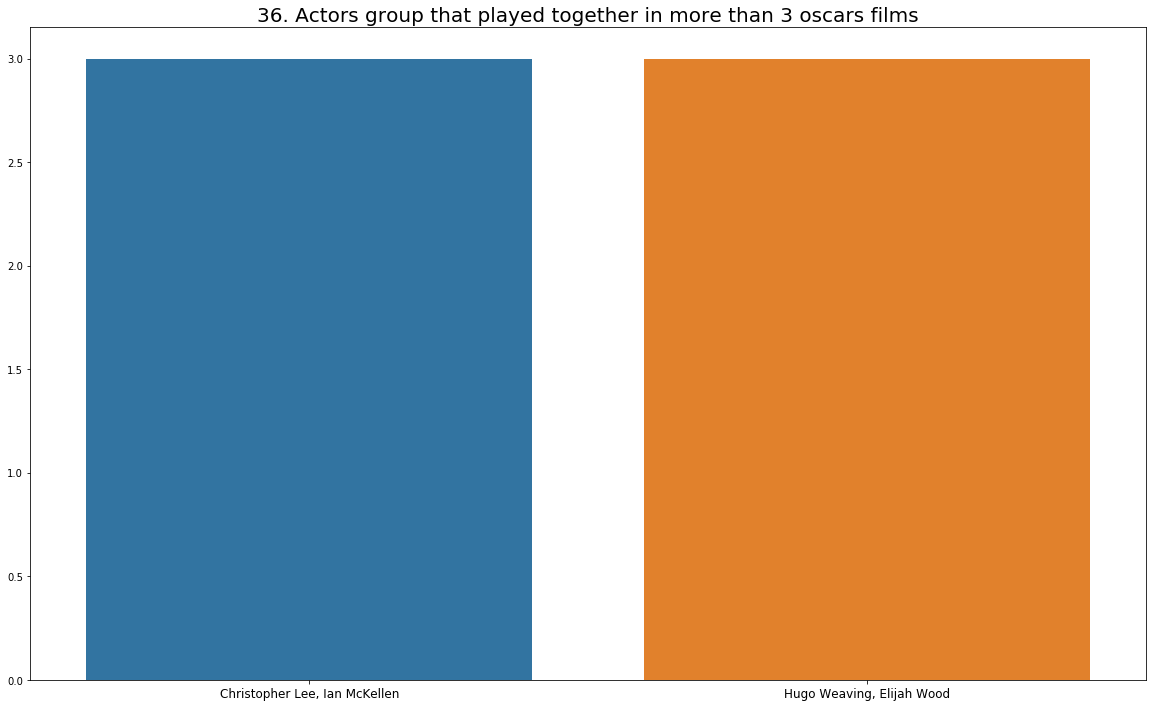

In [13]:
def calculate_support(min_occurence_number, dataset_size):
    return min_occurence_number / dataset_size

# Actors clustering for oscar movies
actorMovieDataset = oscar_movies[['id','title','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
actorMovieDataset = actorMovieDataset['cast']

te = TransactionEncoder()
te_ary = te.fit(actorMovieDataset).transform(actorMovieDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=calculate_support(3,len(df)), use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets.sort_values('length', ascending=True)
plot_itemset("36. Actors group that played together in more than 3 oscars films", frequent_itemsets, len(df), rotation=0)

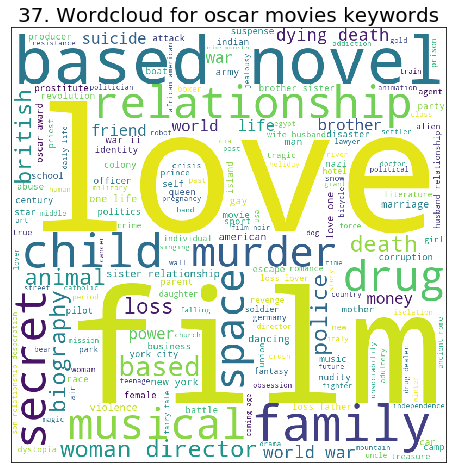

In [16]:
# Keyword words cloud analysis
def createWordCloudForWordsString(wordsString):
    stopwords = set(STOPWORDS) 
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(wordsString) 
    return wordcloud

keywordsMovieDataset = oscar_movies[['id','title','Keywords']].copy()
keywordsMovieDataset['Keywords'] = keywordsMovieDataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
keywordsMovieDataset = keywordsMovieDataset.explode('Keywords').reset_index(drop=True)
keywordsList = keywordsMovieDataset['Keywords'].values.tolist()

oscarMoviesKeywords = ' '

for word in keywordsList: 
    oscarMoviesKeywords = oscarMoviesKeywords + str(word) + ' '

# Plot oscar movies keywords wordcloud                
plt.figure(figsize = (8, 8)) 
plt.imshow(createWordCloudForWordsString(oscarMoviesKeywords)) 
plt.title("37. Wordcloud for oscar movies keywords",fontsize=20)  
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show() 

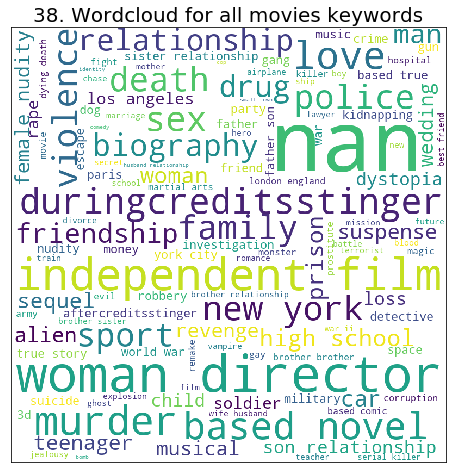

In [17]:
keywordsMovieDataset = dataset[['id','title','Keywords']].copy()
keywordsMovieDataset['Keywords'] = keywordsMovieDataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
keywordsMovieDataset = keywordsMovieDataset.explode('Keywords').reset_index(drop=True)
keywordsList = keywordsMovieDataset['Keywords'].values.tolist()

allMoviesKeywords = ' '

for word in keywordsList: 
    allMoviesKeywords = allMoviesKeywords + str(word) + ' '

# Plot oscar movies keywords wordcloud                
plt.figure(figsize = (8, 8)) 
plt.imshow(createWordCloudForWordsString(allMoviesKeywords)) 
plt.title("38. Wordcloud for all movies keywords",fontsize=20)  
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show() 

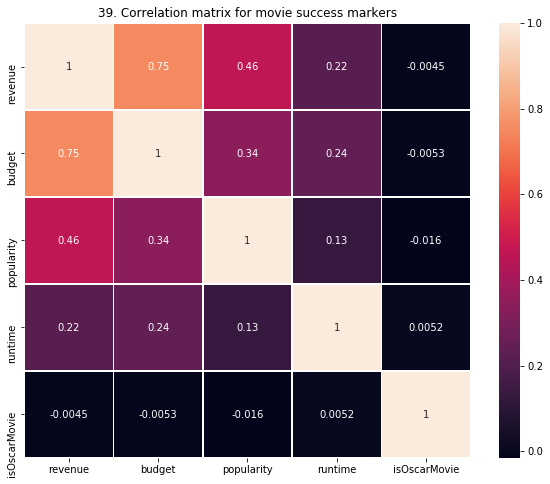

In [18]:
# Making corelation matrix
dataset['isOscarMovie'] = dataset['id'].apply(lambda x: 1 if x in oscar_movies['id'] else 0)
col = ['revenue','budget','popularity','runtime','isOscarMovie']
plt.subplots(figsize=(10, 8))
plt.title('39. Correlation matrix for movie success markers')
corr = dataset[col].corr()
sns.heatmap(corr, annot=True, xticklabels=col,yticklabels=col, linewidths=.5)